<a href="https://colab.research.google.com/github/AI4Finance-LLC/FinRL-Library/blob/master/FinRL_multiple_stock_trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

Tutorials to use OpenAI DRL to trade multiple stocks in one Jupyter Notebook | Presented at NeurIPS 2020: Deep RL Workshop

* This blog is based on our paper: FinRL: A Deep Reinforcement Learning Library for Automated Stock Trading in Quantitative Finance, presented at NeurIPS 2020: Deep RL Workshop.
* Check out medium blog for detailed explanations: https://towardsdatascience.com/finrl-for-quantitative-finance-tutorial-for-multiple-stock-trading-7b00763b7530
* Please report any issues to our Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues
* **Pytorch Version** 



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [1]:
# ## install finrl library
# !pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config import config
from finrl.marketdata.yahoodownloader import YahooDownloader
from finrl.preprocessing.preprocessors import FeatureEngineer
from finrl.preprocessing.data import data_split
from finrl.env.env_stocktrading import StockTradingEnv
from finrl.model.models import DRLAgent,DRLEnsembleAgent
from finrl.trade.backtest import BackTestStats, BaselineStats, BackTestPlot

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")



<a id='1.4'></a>
## 2.4. Create Folders

In [4]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [5]:
# from config.py start_date is a string
config.START_DATE

'2000-01-01'

In [6]:
# from config.py end_date is a string
config.END_DATE

'2021-01-01'

In [7]:
print(config.SRI_KEHATI_TICKER)

['AALI.JK', 'ADHI.JK', 'ASII.JK', 'BBCA.JK', 'BBNI.JK', 'BBRI.JK', 'BBTN.JK', 'BMRI.JK', 'BSDE.JK', 'INDF.JK', 'JPFA.JK', 'JSMR.JK', 'KLBF.JK', 'PGAS.JK', 'PJAA.JK', 'PPRO.JK', 'SIDO.JK', 'SMGR.JK', 'TINS.JK', 'TLKM.JK', 'UNTR.JK', 'UNVR.JK', 'WIKA.JK', 'WSKT.JK', 'WTON.JK']


In [8]:
df = YahooDownloader(start_date = config.START_DATE,
                     end_date = config.END_DATE,
                     ticker_list = config.SRI_KEHATI_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [9]:
#Checking the first inception date for each tickers
df.groupby('tic').min()[['date']].sort_values(by='date')

,date
tic,
UNTR.JK,2000-09-05
INDF.JK,2000-10-02
ASII.JK,2000-10-17
JPFA.JK,2001-01-31
TINS.JK,2001-03-14
AALI.JK,2001-04-05
BMRI.JK,2003-07-14
UNVR.JK,2003-09-03
BBRI.JK,2003-11-10


In [10]:
df = df[~df['tic'].isin(['TLKM.JK','WSKT.JK','SIDO.JK','WTON.JK','PPRO.JK'])]
df = df[df['date']>="2009-12-17"].reset_index(drop=True)

In [11]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2009-12-17,22487.300781,23201.900391,22487.300781,16093.596680,686361,AALI.JK,3
1,2009-12-21,21629.699219,22439.599609,21439.099609,15479.834961,846407,AALI.JK,0
2,2009-12-22,21153.300781,21915.599609,21153.300781,15138.891602,436585,AALI.JK,1
3,2009-12-23,21153.300781,21582.099609,21153.300781,15138.891602,798131,AALI.JK,2
4,2009-12-28,21248.599609,21915.599609,21248.599609,15650.310547,316419,AALI.JK,0


In [12]:
df.shape

(54712, 8)

In [13]:
df.sort_values(['date','tic']).head()

,date,open,high,low,close,volume,tic,day
0,2009-12-17,22487.300781,23201.900391,22487.300781,16093.596680,686361,AALI.JK,3
2736,2009-12-17,356.355988,356.355988,339.386993,282.095795,12134245,ADHI.JK,3
5471,2009-12-17,3500.000000,3560.000000,3445.000000,1223.468262,40,ASII.JK,3
8207,2009-12-17,4850.000000,4875.000000,4825.000000,4146.786133,4419000,BBCA.JK,3
10943,2009-12-17,1848.599976,1886.520020,1839.119995,1335.851440,19465147,BBNI.JK,3


# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [14]:
# Solve the blank line problem,get intersection data

smallest_ticker = df.groupby('tic').count()['date'].idxmin()
smallest_date_list = df[df['tic']==smallest_ticker]['date']

df = df[df['date'].isin(smallest_date_list)].reset_index(drop=True)

In [15]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = config.TECHNICAL_INDICATORS_LIST,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
Successfully added turbulence index


In [16]:
processed.sort_values(['date','tic']).head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
0,2009-12-17,22487.300781,23201.900391,22487.300781,16093.596680,686361,AALI.JK,3,0.0,16654.705967,14918.725674,0.0,-66.666667,100.0,16093.596680,16093.596680,0.0
1,2009-12-17,356.355988,356.355988,339.386993,282.095795,12134245,ADHI.JK,3,0.0,16654.705967,14918.725674,0.0,-66.666667,100.0,282.095795,282.095795,0.0
2,2009-12-17,3500.000000,3560.000000,3445.000000,1223.468262,40,ASII.JK,3,0.0,16654.705967,14918.725674,0.0,-66.666667,100.0,1223.468262,1223.468262,0.0
3,2009-12-17,4850.000000,4875.000000,4825.000000,4146.786133,4419000,BBCA.JK,3,0.0,16654.705967,14918.725674,0.0,-66.666667,100.0,4146.786133,4146.786133,0.0
4,2009-12-17,1848.599976,1886.520020,1839.119995,1335.851440,19465147,BBNI.JK,3,0.0,16654.705967,14918.725674,0.0,-66.666667,100.0,1335.851440,1335.851440,0.0


In [17]:
processed[['turbulence']].describe()

,turbulence
count,54680.000000
mean,23.913079
std,80.939743
min,0.000000
25%,9.294523
50%,16.519940
75%,26.649767
max,3732.739795


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

In [18]:
config.TECHNICAL_INDICATORS_LIST

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [19]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.TECHNICAL_INDICATORS_LIST)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 20, State Space: 201


In [20]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 50_000_000/100, #Since in Indonesia the minimum number of shares per trx is 100, then we scaled the initial amount by dividing it with 100 
    "buy_cost_pct": 0.0019, #IPOT has 0.19% buy cost
    "sell_cost_pct": 0.0029, #IPOT has 0.29% sell cost
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    "print_verbosity":5
    
}

<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

* In this notebook, we are training and validating 3 agents (A2C, PPO, DDPG) using Rolling-window Ensemble Method ([reference code](https://github.com/AI4Finance-LLC/Deep-Reinforcement-Learning-for-Automated-Stock-Trading-Ensemble-Strategy-ICAIF-2020/blob/80415db8fa7b2179df6bd7e81ce4fe8dbf913806/model/models.py#L92))

In [21]:
rebalance_window = 63 # rebalance_window is the number of months to retrain the model
validation_window = 63 # validation_window is the number of months to validation the model and select for trading
train_start = '2009-01-01'
train_end = '2018-01-01'
val_test_start = '2019-01-01'
val_test_end = '2021-01-01'

ensemble_agent = DRLEnsembleAgent(df=processed,
                 train_period=(train_start,train_end),
                 val_test_period=(val_test_start,val_test_end),
                 rebalance_window=rebalance_window, 
                 validation_window=validation_window, 
                 **env_kwargs)

In [22]:
df_summary = ensemble_agent.run_ensemble_strategy()

============Start Ensemble Strategy============
turbulence_threshold:  3732.73979533408
======Model training from:  2009-01-01 to  2019-01-02
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to tensorboard_log/a2c/a2c_126_1
------------------------------------
| time/                 |          |
|    fps                | 105      |
|    iterations         | 100      |
|    time_elapsed       | 4        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -28.4    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 54.8     |
|    std                | 1        |
|    value_loss         | 4.66     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 108      |
|    iterations         | 200      |
|    time_el

------------------------------------
| time/                 |          |
|    fps                | 98       |
|    iterations         | 1500     |
|    time_elapsed       | 75       |
|    total_timesteps    | 7500     |
| train/                |          |
|    entropy_loss       | -28.5    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 1499     |
|    policy_loss        | -0.738   |
|    std                | 1.01     |
|    value_loss         | 0.000966 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 98       |
|    iterations         | 1600     |
|    time_elapsed       | 81       |
|    total_timesteps    | 8000     |
| train/                |          |
|    entropy_loss       | -28.5    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 1599     |
|    policy_loss        | 54       |
|

------------------------------------
| time/                 |          |
|    fps                | 99       |
|    iterations         | 2900     |
|    time_elapsed       | 146      |
|    total_timesteps    | 14500    |
| train/                |          |
|    entropy_loss       | -28.6    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 2899     |
|    policy_loss        | 97.2     |
|    std                | 1.01     |
|    value_loss         | 141      |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 99        |
|    iterations         | 3000      |
|    time_elapsed       | 151       |
|    total_timesteps    | 15000     |
| train/                |           |
|    entropy_loss       | -28.6     |
|    explained_variance | -1.57e+14 |
|    learning_rate      | 0.0007    |
|    n_updates          | 2999      |
|    policy_loss        | 3

------------------------------------
| time/                 |          |
|    fps                | 100      |
|    iterations         | 4300     |
|    time_elapsed       | 214      |
|    total_timesteps    | 21500    |
| train/                |          |
|    entropy_loss       | -28.4    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 4299     |
|    policy_loss        | 218      |
|    std                | 1        |
|    value_loss         | 133      |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 100       |
|    iterations         | 4400      |
|    time_elapsed       | 219       |
|    total_timesteps    | 22000     |
| train/                |           |
|    entropy_loss       | -28.4     |
|    explained_variance | -1.18e+13 |
|    learning_rate      | 0.0007    |
|    n_updates          | 4399      |
|    policy_loss        | -

------------------------------------
| time/                 |          |
|    fps                | 97       |
|    iterations         | 5700     |
|    time_elapsed       | 292      |
|    total_timesteps    | 28500    |
| train/                |          |
|    entropy_loss       | -28.2    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 5699     |
|    policy_loss        | 392      |
|    std                | 0.993    |
|    value_loss         | 240      |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 97       |
|    iterations         | 5800     |
|    time_elapsed       | 297      |
|    total_timesteps    | 29000    |
| train/                |          |
|    entropy_loss       | -28.2    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 5799     |
|    policy_loss        | -279     |
|

------------------------------------
| time/                 |          |
|    fps                | 96       |
|    iterations         | 7100     |
|    time_elapsed       | 369      |
|    total_timesteps    | 35500    |
| train/                |          |
|    entropy_loss       | -28.4    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 7099     |
|    policy_loss        | -15.2    |
|    std                | 1        |
|    value_loss         | 2.31     |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 3e+06    |
|    total_cost         | 4.56e+03 |
|    total_reward       | 2.5e+06  |
|    total_reward_pct   | 500      |
|    total_trades       | 15632    |
| time/                 |          |
|    fps                | 95       |
|    iterations         | 7200     |
|    time_elapsed       | 375      |
|    total_timesteps    | 36000    |
|

------------------------------------
| time/                 |          |
|    fps                | 94       |
|    iterations         | 8500     |
|    time_elapsed       | 450      |
|    total_timesteps    | 42500    |
| train/                |          |
|    entropy_loss       | -28.6    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 8499     |
|    policy_loss        | 15.5     |
|    std                | 1.01     |
|    value_loss         | 0.51     |
------------------------------------
-------------------------------------
| environment/          |           |
|    portfolio_value    | 1.11e+06  |
|    total_cost         | 948       |
|    total_reward       | 6.14e+05  |
|    total_reward_pct   | 123       |
|    total_trades       | 18304     |
| time/                 |           |
|    fps                | 94        |
|    iterations         | 8600      |
|    time_elapsed       | 456       |
|    total_timesteps    | 4

------------------------------------
| environment/          |          |
|    portfolio_value    | 1.11e+06 |
|    total_cost         | 949      |
|    total_reward       | 6.14e+05 |
|    total_reward_pct   | 123      |
|    total_trades       | 16998    |
| time/                 |          |
|    fps                | 93       |
|    iterations         | 9900     |
|    time_elapsed       | 529      |
|    total_timesteps    | 49500    |
| train/                |          |
|    entropy_loss       | -28.8    |
|    explained_variance | -7.5e+12 |
|    learning_rate      | 0.0007   |
|    n_updates          | 9899     |
|    policy_loss        | 19.6     |
|    std                | 1.02     |
|    value_loss         | 0.897    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 93       |
|    iterations         | 10000    |
|    time_elapsed       | 535      |
|    total_timesteps    | 50000    |
|

-------------------------------------
| time/                 |           |
|    fps                | 92        |
|    iterations         | 11300     |
|    time_elapsed       | 610       |
|    total_timesteps    | 56500     |
| train/                |           |
|    entropy_loss       | -28.9     |
|    explained_variance | -4.05e+12 |
|    learning_rate      | 0.0007    |
|    n_updates          | 11299     |
|    policy_loss        | 2.65      |
|    std                | 1.03      |
|    value_loss         | 0.927     |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 92       |
|    iterations         | 11400    |
|    time_elapsed       | 617      |
|    total_timesteps    | 57000    |
| train/                |          |
|    entropy_loss       | -29      |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 11399    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 91       |
|    iterations         | 12700    |
|    time_elapsed       | 692      |
|    total_timesteps    | 63500    |
| train/                |          |
|    entropy_loss       | -29.3    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 12699    |
|    policy_loss        | -330     |
|    std                | 1.05     |
|    value_loss         | 155      |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 91       |
|    iterations         | 12800    |
|    time_elapsed       | 698      |
|    total_timesteps    | 64000    |
| train/                |          |
|    entropy_loss       | -29.3    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 12799    |
|    policy_loss        | -130     |
|

------------------------------------
| time/                 |          |
|    fps                | 91       |
|    iterations         | 14100    |
|    time_elapsed       | 771      |
|    total_timesteps    | 70500    |
| train/                |          |
|    entropy_loss       | -29.4    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 14099    |
|    policy_loss        | -27      |
|    std                | 1.05     |
|    value_loss         | 1.39     |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 91        |
|    iterations         | 14200     |
|    time_elapsed       | 777       |
|    total_timesteps    | 71000     |
| train/                |           |
|    entropy_loss       | -29.3     |
|    explained_variance | -1.48e+13 |
|    learning_rate      | 0.0007    |
|    n_updates          | 14199     |
|    policy_loss        | 6

------------------------------------
| time/                 |          |
|    fps                | 91       |
|    iterations         | 15500    |
|    time_elapsed       | 850      |
|    total_timesteps    | 77500    |
| train/                |          |
|    entropy_loss       | -29.4    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 15499    |
|    policy_loss        | 186      |
|    std                | 1.05     |
|    value_loss         | 72.7     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 91       |
|    iterations         | 15600    |
|    time_elapsed       | 856      |
|    total_timesteps    | 78000    |
| train/                |          |
|    entropy_loss       | -29.4    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 15599    |
|    policy_loss        | 73.4     |
|

------------------------------------
| time/                 |          |
|    fps                | 90       |
|    iterations         | 16900    |
|    time_elapsed       | 931      |
|    total_timesteps    | 84500    |
| train/                |          |
|    entropy_loss       | -29.6    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 16899    |
|    policy_loss        | -54.8    |
|    std                | 1.07     |
|    value_loss         | 6.21     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 90       |
|    iterations         | 17000    |
|    time_elapsed       | 937      |
|    total_timesteps    | 85000    |
| train/                |          |
|    entropy_loss       | -29.6    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 16999    |
|    policy_loss        | -110     |
|

------------------------------------
| time/                 |          |
|    fps                | 90       |
|    iterations         | 18300    |
|    time_elapsed       | 1014     |
|    total_timesteps    | 91500    |
| train/                |          |
|    entropy_loss       | -29.8    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 18299    |
|    policy_loss        | -97.2    |
|    std                | 1.07     |
|    value_loss         | 14.9     |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 1.99e+06 |
|    total_cost         | 6.6e+03  |
|    total_reward       | 1.49e+06 |
|    total_reward_pct   | 297      |
|    total_trades       | 21072    |
| time/                 |          |
|    fps                | 90       |
|    iterations         | 18400    |
|    time_elapsed       | 1019     |
|    total_timesteps    | 92000    |
|

------------------------------------
| environment/          |          |
|    portfolio_value    | 2.41e+06 |
|    total_cost         | 5.73e+03 |
|    total_reward       | 1.91e+06 |
|    total_reward_pct   | 382      |
|    total_trades       | 21474    |
| time/                 |          |
|    fps                | 90       |
|    iterations         | 19700    |
|    time_elapsed       | 1093     |
|    total_timesteps    | 98500    |
| train/                |          |
|    entropy_loss       | -29.9    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 19699    |
|    policy_loss        | -38.6    |
|    std                | 1.09     |
|    value_loss         | 1.8      |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 90       |
|    iterations         | 19800    |
|    time_elapsed       | 1099     |
|    total_timesteps    | 99000    |
|

------------------------------------------
| environment/            |              |
|    portfolio_value      | 7.26e+03     |
|    total_cost           | 4.02e+05     |
|    total_reward         | -4.93e+05    |
|    total_reward_pct     | -98.5        |
|    total_trades         | 25896        |
| time/                   |              |
|    fps                  | 150          |
|    iterations           | 7            |
|    time_elapsed         | 95           |
|    total_timesteps      | 14336        |
| train/                  |              |
|    approx_kl            | 0.0138657475 |
|    clip_fraction        | 0.176        |
|    clip_range           | 0.2          |
|    entropy_loss         | -28.6        |
|    explained_variance   | -4.1         |
|    learning_rate        | 0.00025      |
|    loss                 | 0.357        |
|    n_updates            | 60           |
|    policy_gradient_loss | -0.0141      |
|    std                  | 1.01         |
|    value_

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 3.3e+04     |
|    total_cost           | 4.67e+05    |
|    total_reward         | -4.67e+05   |
|    total_reward_pct     | -93.4       |
|    total_trades         | 26190       |
| time/                   |             |
|    fps                  | 149         |
|    iterations           | 15          |
|    time_elapsed         | 205         |
|    total_timesteps      | 30720       |
| train/                  |             |
|    approx_kl            | 0.016752977 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    entropy_loss         | -29         |
|    explained_variance   | -3.6        |
|    learning_rate        | 0.00025     |
|    loss                 | 1.12        |
|    n_updates            | 140         |
|    policy_gradient_loss | -0.0123     |
|    std                  | 1.03        |
|    value_loss           | 2.66  

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.61e+04    |
|    total_cost           | 5.91e+05    |
|    total_reward         | -4.74e+05   |
|    total_reward_pct     | -94.8       |
|    total_trades         | 26857       |
| time/                   |             |
|    fps                  | 149         |
|    iterations           | 23          |
|    time_elapsed         | 315         |
|    total_timesteps      | 47104       |
| train/                  |             |
|    approx_kl            | 0.010630654 |
|    clip_fraction        | 0.104       |
|    clip_range           | 0.2         |
|    entropy_loss         | -29.3       |
|    explained_variance   | -16         |
|    learning_rate        | 0.00025     |
|    loss                 | 1.55        |
|    n_updates            | 220         |
|    policy_gradient_loss | -0.0082     |
|    std                  | 1.05        |
|    value_loss           | 6.01  

------------------------------------------
| environment/            |              |
|    portfolio_value      | 4.2e+05      |
|    total_cost           | 1.17e+06     |
|    total_reward         | -8.01e+04    |
|    total_reward_pct     | -16          |
|    total_trades         | 27821        |
| time/                   |              |
|    fps                  | 149          |
|    iterations           | 31           |
|    time_elapsed         | 424          |
|    total_timesteps      | 63488        |
| train/                  |              |
|    approx_kl            | 0.0035210084 |
|    clip_fraction        | 0.0788       |
|    clip_range           | 0.2          |
|    entropy_loss         | -29.5        |
|    explained_variance   | -10.5        |
|    learning_rate        | 0.00025      |
|    loss                 | 10.5         |
|    n_updates            | 300          |
|    policy_gradient_loss | -0.00778     |
|    std                  | 1.06         |
|    value_

day: 2236, episode: 80
begin_total_asset: 500000.00
end_total_asset: 2495204.96
total_reward: 1995204.96
total_cost: 817985.57
total_trades: 26730
Sharpe: 0.654
------------------------------------------
| environment/            |              |
|    portfolio_value      | 2.5e+06      |
|    total_cost           | 8.18e+05     |
|    total_reward         | 2e+06        |
|    total_reward_pct     | 399          |
|    total_trades         | 26730        |
| time/                   |              |
|    fps                  | 149          |
|    iterations           | 39           |
|    time_elapsed         | 535          |
|    total_timesteps      | 79872        |
| train/                  |              |
|    approx_kl            | 0.0084270295 |
|    clip_fraction        | 0.0349       |
|    clip_range           | 0.2          |
|    entropy_loss         | -29.7        |
|    explained_variance   | -5.23        |
|    learning_rate        | 0.00025      |
|    loss             

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 1.83e+06    |
|    total_cost           | 6.48e+05    |
|    total_reward         | 1.33e+06    |
|    total_reward_pct     | 265         |
|    total_trades         | 26522       |
| time/                   |             |
|    fps                  | 150         |
|    iterations           | 47          |
|    time_elapsed         | 639         |
|    total_timesteps      | 96256       |
| train/                  |             |
|    approx_kl            | 0.010572236 |
|    clip_fraction        | 0.0675      |
|    clip_range           | 0.2         |
|    entropy_loss         | -29.8       |
|    explained_variance   | -0.64       |
|    learning_rate        | 0.00025     |
|    loss                 | 155         |
|    n_updates            | 460         |
|    policy_gradient_loss | -0.00608    |
|    std                  | 1.07        |
|    value_loss           | 301   

------------------------------------
| time/                 |          |
|    fps                | 89       |
|    iterations         | 200      |
|    time_elapsed       | 11       |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -28.4    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|    policy_loss        | 142      |
|    std                | 1        |
|    value_loss         | 37.5     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 90       |
|    iterations         | 300      |
|    time_elapsed       | 16       |
|    total_timesteps    | 1500     |
| train/                |          |
|    entropy_loss       | -28.4    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 299      |
|    policy_loss        | 90.2     |
|

------------------------------------
| time/                 |          |
|    fps                | 94       |
|    iterations         | 1600     |
|    time_elapsed       | 84       |
|    total_timesteps    | 8000     |
| train/                |          |
|    entropy_loss       | -28.6    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 1599     |
|    policy_loss        | -124     |
|    std                | 1.01     |
|    value_loss         | 15.7     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 94       |
|    iterations         | 1700     |
|    time_elapsed       | 89       |
|    total_timesteps    | 8500     |
| train/                |          |
|    entropy_loss       | -28.7    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 1699     |
|    policy_loss        | 114      |
|

------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 3000     |
|    time_elapsed       | 156      |
|    total_timesteps    | 15000    |
| train/                |          |
|    entropy_loss       | -28.9    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 2999     |
|    policy_loss        | -1.55    |
|    std                | 1.03     |
|    value_loss         | 0.509    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 3100     |
|    time_elapsed       | 161      |
|    total_timesteps    | 15500    |
| train/                |          |
|    entropy_loss       | -28.8    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 3099     |
|    policy_loss        | 20.3     |
|

-------------------------------------
| time/                 |           |
|    fps                | 95        |
|    iterations         | 4400      |
|    time_elapsed       | 229       |
|    total_timesteps    | 22000     |
| train/                |           |
|    entropy_loss       | -29.1     |
|    explained_variance | -3.63e+12 |
|    learning_rate      | 0.0007    |
|    n_updates          | 4399      |
|    policy_loss        | -30       |
|    std                | 1.04      |
|    value_loss         | 3.89      |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 96       |
|    iterations         | 4500     |
|    time_elapsed       | 234      |
|    total_timesteps    | 22500    |
| train/                |          |
|    entropy_loss       | -29.1    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 4499     |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 96       |
|    iterations         | 5800     |
|    time_elapsed       | 302      |
|    total_timesteps    | 29000    |
| train/                |          |
|    entropy_loss       | -29.3    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 5799     |
|    policy_loss        | 4.83     |
|    std                | 1.05     |
|    value_loss         | 0.765    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 96       |
|    iterations         | 5900     |
|    time_elapsed       | 307      |
|    total_timesteps    | 29500    |
| train/                |          |
|    entropy_loss       | -29.3    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 5899     |
|    policy_loss        | 70.3     |
|

------------------------------------
| time/                 |          |
|    fps                | 96       |
|    iterations         | 7200     |
|    time_elapsed       | 374      |
|    total_timesteps    | 36000    |
| train/                |          |
|    entropy_loss       | -29.6    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 7199     |
|    policy_loss        | 190      |
|    std                | 1.06     |
|    value_loss         | 50.8     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 96       |
|    iterations         | 7300     |
|    time_elapsed       | 379      |
|    total_timesteps    | 36500    |
| train/                |          |
|    entropy_loss       | -29.6    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 7299     |
|    policy_loss        | 16.9     |
|

------------------------------------
| time/                 |          |
|    fps                | 96       |
|    iterations         | 8600     |
|    time_elapsed       | 445      |
|    total_timesteps    | 43000    |
| train/                |          |
|    entropy_loss       | -29.9    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 8599     |
|    policy_loss        | -165     |
|    std                | 1.08     |
|    value_loss         | 40.6     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 96       |
|    iterations         | 8700     |
|    time_elapsed       | 450      |
|    total_timesteps    | 43500    |
| train/                |          |
|    entropy_loss       | -29.9    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 8699     |
|    policy_loss        | -3.87    |
|

-------------------------------------
| time/                 |           |
|    fps                | 96        |
|    iterations         | 10000     |
|    time_elapsed       | 518       |
|    total_timesteps    | 50000     |
| train/                |           |
|    entropy_loss       | -30.2     |
|    explained_variance | -1.79e+13 |
|    learning_rate      | 0.0007    |
|    n_updates          | 9999      |
|    policy_loss        | -37       |
|    std                | 1.1       |
|    value_loss         | 2.66      |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 96       |
|    iterations         | 10100    |
|    time_elapsed       | 524      |
|    total_timesteps    | 50500    |
| train/                |          |
|    entropy_loss       | -30.3    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 10099    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 96       |
|    iterations         | 11400    |
|    time_elapsed       | 591      |
|    total_timesteps    | 57000    |
| train/                |          |
|    entropy_loss       | -30.3    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 11399    |
|    policy_loss        | -29.2    |
|    std                | 1.1      |
|    value_loss         | 0.884    |
------------------------------------
day: 2299, episode: 25
begin_total_asset: 500000.00
end_total_asset: 2445694.07
total_reward: 1945694.07
total_cost: 86834.21
total_trades: 27456
Sharpe: 0.679
------------------------------------
| environment/          |          |
|    portfolio_value    | 2.45e+06 |
|    total_cost         | 8.68e+04 |
|    total_reward       | 1.95e+06 |
|    total_reward_pct   | 389      |
|    total_trades       | 27456    |
| time/                 | 

------------------------------------
| time/                 |          |
|    fps                | 96       |
|    iterations         | 12800    |
|    time_elapsed       | 664      |
|    total_timesteps    | 64000    |
| train/                |          |
|    entropy_loss       | -30.5    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 12799    |
|    policy_loss        | 112      |
|    std                | 1.12     |
|    value_loss         | 21.1     |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 1.78e+06 |
|    total_cost         | 7.6e+03  |
|    total_reward       | 1.28e+06 |
|    total_reward_pct   | 255      |
|    total_trades       | 23325    |
| time/                 |          |
|    fps                | 96       |
|    iterations         | 12900    |
|    time_elapsed       | 670      |
|    total_timesteps    | 64500    |
|

------------------------------------
| time/                 |          |
|    fps                | 96       |
|    iterations         | 14200    |
|    time_elapsed       | 737      |
|    total_timesteps    | 71000    |
| train/                |          |
|    entropy_loss       | -30.8    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 14199    |
|    policy_loss        | 11.7     |
|    std                | 1.13     |
|    value_loss         | 0.615    |
------------------------------------
-------------------------------------
| environment/          |           |
|    portfolio_value    | 1.33e+06  |
|    total_cost         | 2.23e+03  |
|    total_reward       | 8.29e+05  |
|    total_reward_pct   | 166       |
|    total_trades       | 19051     |
| time/                 |           |
|    fps                | 96        |
|    iterations         | 14300     |
|    time_elapsed       | 741       |
|    total_timesteps    | 7

------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 15600    |
|    time_elapsed       | 812      |
|    total_timesteps    | 78000    |
| train/                |          |
|    entropy_loss       | -31.1    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 15599    |
|    policy_loss        | -2.66    |
|    std                | 1.15     |
|    value_loss         | 0.0103   |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 1.59e+06 |
|    total_cost         | 3.49e+04 |
|    total_reward       | 1.09e+06 |
|    total_reward_pct   | 218      |
|    total_trades       | 24687    |
| time/                 |          |
|    fps                | 95       |
|    iterations         | 15700    |
|    time_elapsed       | 817      |
|    total_timesteps    | 78500    |
|

------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 17000    |
|    time_elapsed       | 885      |
|    total_timesteps    | 85000    |
| train/                |          |
|    entropy_loss       | -31.4    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 16999    |
|    policy_loss        | 62.3     |
|    std                | 1.17     |
|    value_loss         | 7.68     |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 1.19e+06 |
|    total_cost         | 1.49e+04 |
|    total_reward       | 6.88e+05 |
|    total_reward_pct   | 138      |
|    total_trades       | 19454    |
| time/                 |          |
|    fps                | 95       |
|    iterations         | 17100    |
|    time_elapsed       | 891      |
|    total_timesteps    | 85500    |
|

day: 2299, episode: 40
begin_total_asset: 500000.00
end_total_asset: 1655365.49
total_reward: 1155365.49
total_cost: 31913.18
total_trades: 18558
Sharpe: 0.598
------------------------------------
| environment/          |          |
|    portfolio_value    | 1.66e+06 |
|    total_cost         | 3.19e+04 |
|    total_reward       | 1.16e+06 |
|    total_reward_pct   | 231      |
|    total_trades       | 18558    |
| time/                 |          |
|    fps                | 95       |
|    iterations         | 18400    |
|    time_elapsed       | 958      |
|    total_timesteps    | 92000    |
| train/                |          |
|    entropy_loss       | -31.5    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 18399    |
|    policy_loss        | -194     |
|    std                | 1.17     |
|    value_loss         | 42.5     |
------------------------------------
------------------------------------
| time/                 | 

-------------------------------------
| environment/          |           |
|    portfolio_value    | 2.67e+06  |
|    total_cost         | 1.57e+04  |
|    total_reward       | 2.17e+06  |
|    total_reward_pct   | 435       |
|    total_trades       | 17109     |
| time/                 |           |
|    fps                | 96        |
|    iterations         | 19800     |
|    time_elapsed       | 1030      |
|    total_timesteps    | 99000     |
| train/                |           |
|    entropy_loss       | -31.5     |
|    explained_variance | -1.56e+04 |
|    learning_rate      | 0.0007    |
|    n_updates          | 19799     |
|    policy_loss        | -7.51     |
|    std                | 1.17      |
|    value_loss         | 1.77      |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 96        |
|    iterations         | 19900     |
|    time_elapsed       | 1036      |
|    total_t

----------------------------------------
| environment/            |            |
|    portfolio_value      | 2.86e+04   |
|    total_cost           | 5.75e+05   |
|    total_reward         | -4.71e+05  |
|    total_reward_pct     | -94.3      |
|    total_trades         | 27201      |
| time/                   |            |
|    fps                  | 161        |
|    iterations           | 8          |
|    time_elapsed         | 101        |
|    total_timesteps      | 16384      |
| train/                  |            |
|    approx_kl            | 0.00909631 |
|    clip_fraction        | 0.163      |
|    clip_range           | 0.2        |
|    entropy_loss         | -28.5      |
|    explained_variance   | -0.491     |
|    learning_rate        | 0.00025    |
|    loss                 | 0.432      |
|    n_updates            | 70         |
|    policy_gradient_loss | -0.0107    |
|    std                  | 1.01       |
|    value_loss           | 2.27       |
----------------

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 9.77e+04    |
|    total_cost           | 4.56e+05    |
|    total_reward         | -4.02e+05   |
|    total_reward_pct     | -80.5       |
|    total_trades         | 26846       |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 16          |
|    time_elapsed         | 204         |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.008418273 |
|    clip_fraction        | 0.144       |
|    clip_range           | 0.2         |
|    entropy_loss         | -28.9       |
|    explained_variance   | -4.07       |
|    learning_rate        | 0.00025     |
|    loss                 | 1.15        |
|    n_updates            | 150         |
|    policy_gradient_loss | -0.0126     |
|    std                  | 1.03        |
|    value_loss           | 3.57  

day: 2299, episode: 65
begin_total_asset: 500000.00
end_total_asset: 6566.12
total_reward: -493433.88
total_cost: 430999.67
total_trades: 26550
Sharpe: -1.126
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 6.57e+03    |
|    total_cost           | 4.31e+05    |
|    total_reward         | -4.93e+05   |
|    total_reward_pct     | -98.7       |
|    total_trades         | 26550       |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 24          |
|    time_elapsed         | 306         |
|    total_timesteps      | 49152       |
| train/                  |             |
|    approx_kl            | 0.019333966 |
|    clip_fraction        | 0.154       |
|    clip_range           | 0.2         |
|    entropy_loss         | -29.2       |
|    explained_variance   | -1.3        |
|    learning_rate        | 0.00025     |
|    loss                 | 1.07        |
|

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 3.86e+03    |
|    total_cost           | 3.32e+05    |
|    total_reward         | -4.96e+05   |
|    total_reward_pct     | -99.2       |
|    total_trades         | 26399       |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 32          |
|    time_elapsed         | 408         |
|    total_timesteps      | 65536       |
| train/                  |             |
|    approx_kl            | 0.008072108 |
|    clip_fraction        | 0.209       |
|    clip_range           | 0.2         |
|    entropy_loss         | -29.5       |
|    explained_variance   | -1.03       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.882       |
|    n_updates            | 310         |
|    policy_gradient_loss | -0.00699    |
|    std                  | 1.06        |
|    value_loss           | 2.3   

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 1.92e+05    |
|    total_cost           | 1.08e+06    |
|    total_reward         | -3.08e+05   |
|    total_reward_pct     | -61.6       |
|    total_trades         | 28019       |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 40          |
|    time_elapsed         | 511         |
|    total_timesteps      | 81920       |
| train/                  |             |
|    approx_kl            | 0.008205985 |
|    clip_fraction        | 0.0904      |
|    clip_range           | 0.2         |
|    entropy_loss         | -29.7       |
|    explained_variance   | -10.3       |
|    learning_rate        | 0.00025     |
|    loss                 | 21.2        |
|    n_updates            | 390         |
|    policy_gradient_loss | -0.00974    |
|    std                  | 1.07        |
|    value_loss           | 33.6  

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.48e+06    |
|    total_cost           | 1.29e+06    |
|    total_reward         | 1.98e+06    |
|    total_reward_pct     | 395         |
|    total_trades         | 28158       |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 48          |
|    time_elapsed         | 614         |
|    total_timesteps      | 98304       |
| train/                  |             |
|    approx_kl            | 0.009909149 |
|    clip_fraction        | 0.0521      |
|    clip_range           | 0.2         |
|    entropy_loss         | -29.9       |
|    explained_variance   | -7.53       |
|    learning_rate        | 0.00025     |
|    loss                 | 106         |
|    n_updates            | 470         |
|    policy_gradient_loss | -0.00631    |
|    std                  | 1.08        |
|    value_loss           | 166   

-------------------------------------
| time/                 |           |
|    fps                | 91        |
|    iterations         | 300       |
|    time_elapsed       | 16        |
|    total_timesteps    | 1500      |
| train/                |           |
|    entropy_loss       | -28.4     |
|    explained_variance | -1.34e+14 |
|    learning_rate      | 0.0007    |
|    n_updates          | 299       |
|    policy_loss        | 7.17      |
|    std                | 1         |
|    value_loss         | 0.592     |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 91       |
|    iterations         | 400      |
|    time_elapsed       | 21       |
|    total_timesteps    | 2000     |
| train/                |          |
|    entropy_loss       | -28.4    |
|    explained_variance | -16.4    |
|    learning_rate      | 0.0007   |
|    n_updates          | 399      |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 92       |
|    iterations         | 1700     |
|    time_elapsed       | 91       |
|    total_timesteps    | 8500     |
| train/                |          |
|    entropy_loss       | -28.5    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 1699     |
|    policy_loss        | -4.94    |
|    std                | 1.01     |
|    value_loss         | 0.677    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 91       |
|    iterations         | 1800     |
|    time_elapsed       | 98       |
|    total_timesteps    | 9000     |
| train/                |          |
|    entropy_loss       | -28.4    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 1799     |
|    policy_loss        | -37      |
|

------------------------------------
| time/                 |          |
|    fps                | 91       |
|    iterations         | 3100     |
|    time_elapsed       | 168      |
|    total_timesteps    | 15500    |
| train/                |          |
|    entropy_loss       | -28.4    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 3099     |
|    policy_loss        | -51.5    |
|    std                | 1        |
|    value_loss         | 4.93     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 90       |
|    iterations         | 3200     |
|    time_elapsed       | 177      |
|    total_timesteps    | 16000    |
| train/                |          |
|    entropy_loss       | -28.4    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 3199     |
|    policy_loss        | 98.5     |
|

------------------------------------
| time/                 |          |
|    fps                | 90       |
|    iterations         | 4500     |
|    time_elapsed       | 248      |
|    total_timesteps    | 22500    |
| train/                |          |
|    entropy_loss       | -28.6    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 4499     |
|    policy_loss        | -7.86    |
|    std                | 1.01     |
|    value_loss         | 0.14     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 90       |
|    iterations         | 4600     |
|    time_elapsed       | 253      |
|    total_timesteps    | 23000    |
| train/                |          |
|    entropy_loss       | -28.6    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 4599     |
|    policy_loss        | -4.96    |
|

------------------------------------
| time/                 |          |
|    fps                | 91       |
|    iterations         | 5900     |
|    time_elapsed       | 323      |
|    total_timesteps    | 29500    |
| train/                |          |
|    entropy_loss       | -28.9    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 5899     |
|    policy_loss        | 24.5     |
|    std                | 1.03     |
|    value_loss         | 1.3      |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 91       |
|    iterations         | 6000     |
|    time_elapsed       | 328      |
|    total_timesteps    | 30000    |
| train/                |          |
|    entropy_loss       | -28.9    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 5999     |
|    policy_loss        | 5.45     |
|

------------------------------------
| time/                 |          |
|    fps                | 91       |
|    iterations         | 7300     |
|    time_elapsed       | 399      |
|    total_timesteps    | 36500    |
| train/                |          |
|    entropy_loss       | -29.1    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 7299     |
|    policy_loss        | 26.6     |
|    std                | 1.04     |
|    value_loss         | 2.54     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 91       |
|    iterations         | 7400     |
|    time_elapsed       | 404      |
|    total_timesteps    | 37000    |
| train/                |          |
|    entropy_loss       | -29.1    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 7399     |
|    policy_loss        | 2.4      |
|

------------------------------------
| time/                 |          |
|    fps                | 91       |
|    iterations         | 8700     |
|    time_elapsed       | 473      |
|    total_timesteps    | 43500    |
| train/                |          |
|    entropy_loss       | -29.4    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 8699     |
|    policy_loss        | -33      |
|    std                | 1.05     |
|    value_loss         | 2.49     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 91       |
|    iterations         | 8800     |
|    time_elapsed       | 478      |
|    total_timesteps    | 44000    |
| train/                |          |
|    entropy_loss       | -29.3    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 8799     |
|    policy_loss        | -5.17    |
|

------------------------------------
| time/                 |          |
|    fps                | 92       |
|    iterations         | 10100    |
|    time_elapsed       | 547      |
|    total_timesteps    | 50500    |
| train/                |          |
|    entropy_loss       | -29.5    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 10099    |
|    policy_loss        | 79.8     |
|    std                | 1.06     |
|    value_loss         | 40.6     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 92       |
|    iterations         | 10200    |
|    time_elapsed       | 552      |
|    total_timesteps    | 51000    |
| train/                |          |
|    entropy_loss       | -29.5    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 10199    |
|    policy_loss        | -68.8    |
|

------------------------------------
| time/                 |          |
|    fps                | 92       |
|    iterations         | 11500    |
|    time_elapsed       | 620      |
|    total_timesteps    | 57500    |
| train/                |          |
|    entropy_loss       | -29.5    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 11499    |
|    policy_loss        | 137      |
|    std                | 1.06     |
|    value_loss         | 23.8     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 92       |
|    iterations         | 11600    |
|    time_elapsed       | 626      |
|    total_timesteps    | 58000    |
| train/                |          |
|    entropy_loss       | -29.6    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 11599    |
|    policy_loss        | 207      |
|

-------------------------------------
| time/                 |           |
|    fps                | 92        |
|    iterations         | 12900     |
|    time_elapsed       | 696       |
|    total_timesteps    | 64500     |
| train/                |           |
|    entropy_loss       | -29.8     |
|    explained_variance | -1.57e+11 |
|    learning_rate      | 0.0007    |
|    n_updates          | 12899     |
|    policy_loss        | 22        |
|    std                | 1.08      |
|    value_loss         | 0.589     |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 92       |
|    iterations         | 13000    |
|    time_elapsed       | 701      |
|    total_timesteps    | 65000    |
| train/                |          |
|    entropy_loss       | -29.9    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 12999    |
|    policy_loss       

-------------------------------------
| time/                 |           |
|    fps                | 92        |
|    iterations         | 14300     |
|    time_elapsed       | 769       |
|    total_timesteps    | 71500     |
| train/                |           |
|    entropy_loss       | -30.2     |
|    explained_variance | -8.42e+12 |
|    learning_rate      | 0.0007    |
|    n_updates          | 14299     |
|    policy_loss        | 38.3      |
|    std                | 1.1       |
|    value_loss         | 3.46      |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 93       |
|    iterations         | 14400    |
|    time_elapsed       | 774      |
|    total_timesteps    | 72000    |
| train/                |          |
|    entropy_loss       | -30.2    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 14399    |
|    policy_loss       

-------------------------------------
| time/                 |           |
|    fps                | 92        |
|    iterations         | 15700     |
|    time_elapsed       | 844       |
|    total_timesteps    | 78500     |
| train/                |           |
|    entropy_loss       | -30.3     |
|    explained_variance | -4.24e+12 |
|    learning_rate      | 0.0007    |
|    n_updates          | 15699     |
|    policy_loss        | 4.41      |
|    std                | 1.11      |
|    value_loss         | 1.01      |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 92       |
|    iterations         | 15800    |
|    time_elapsed       | 849      |
|    total_timesteps    | 79000    |
| train/                |          |
|    entropy_loss       | -30.3    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 15799    |
|    policy_loss       

------------------------------------
| environment/          |          |
|    portfolio_value    | 2.17e+06 |
|    total_cost         | 3.9e+03  |
|    total_reward       | 1.67e+06 |
|    total_reward_pct   | 334      |
|    total_trades       | 27056    |
| time/                 |          |
|    fps                | 92       |
|    iterations         | 17100    |
|    time_elapsed       | 920      |
|    total_timesteps    | 85500    |
| train/                |          |
|    entropy_loss       | -30.5    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 17099    |
|    policy_loss        | -143     |
|    std                | 1.11     |
|    value_loss         | 33.8     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 92       |
|    iterations         | 17200    |
|    time_elapsed       | 925      |
|    total_timesteps    | 86000    |
|

------------------------------------
| environment/          |          |
|    portfolio_value    | 3.97e+06 |
|    total_cost         | 1.57e+04 |
|    total_reward       | 3.47e+06 |
|    total_reward_pct   | 694      |
|    total_trades       | 22386    |
| time/                 |          |
|    fps                | 93       |
|    iterations         | 18500    |
|    time_elapsed       | 994      |
|    total_timesteps    | 92500    |
| train/                |          |
|    entropy_loss       | -30.5    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 18499    |
|    policy_loss        | -34      |
|    std                | 1.12     |
|    value_loss         | 1.9      |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 93       |
|    iterations         | 18600    |
|    time_elapsed       | 999      |
|    total_timesteps    | 93000    |
|

------------------------------------
| environment/          |          |
|    portfolio_value    | 3.75e+06 |
|    total_cost         | 7.36e+03 |
|    total_reward       | 3.25e+06 |
|    total_reward_pct   | 651      |
|    total_trades       | 18148    |
| time/                 |          |
|    fps                | 93       |
|    iterations         | 19900    |
|    time_elapsed       | 1068     |
|    total_timesteps    | 99500    |
| train/                |          |
|    entropy_loss       | -30.7    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 19899    |
|    policy_loss        | 36.5     |
|    std                | 1.13     |
|    value_loss         | 1.99     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 93       |
|    iterations         | 20000    |
|    time_elapsed       | 1073     |
|    total_timesteps    | 100000   |
|

-----------------------------------------
| time/                   |             |
|    fps                  | 157         |
|    iterations           | 8           |
|    time_elapsed         | 103         |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.012525289 |
|    clip_fraction        | 0.156       |
|    clip_range           | 0.2         |
|    entropy_loss         | -28.7       |
|    explained_variance   | -1.72       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.712       |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.017      |
|    std                  | 1.02        |
|    value_loss           | 1.85        |
-----------------------------------------
day: 2362, episode: 50
begin_total_asset: 500000.00
end_total_asset: 9137.96
total_reward: -490862.04
total_cost: 412084.60
total_trades: 27432
Sharpe: -1.137
-----------------------------------------
|

-----------------------------------------
| time/                   |             |
|    fps                  | 157         |
|    iterations           | 16          |
|    time_elapsed         | 207         |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.022438891 |
|    clip_fraction        | 0.13        |
|    clip_range           | 0.2         |
|    entropy_loss         | -29.1       |
|    explained_variance   | -4.07       |
|    learning_rate        | 0.00025     |
|    loss                 | 1.31        |
|    n_updates            | 150         |
|    policy_gradient_loss | -0.0195     |
|    std                  | 1.04        |
|    value_loss           | 2.44        |
-----------------------------------------
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 3.19e+04    |
|    total_cost           | 5.15e+05    |
|    total_reward         | -4.68e

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2e+04       |
|    total_cost           | 3.58e+05    |
|    total_reward         | -4.8e+05    |
|    total_reward_pct     | -96         |
|    total_trades         | 28202       |
| time/                   |             |
|    fps                  | 157         |
|    iterations           | 25          |
|    time_elapsed         | 325         |
|    total_timesteps      | 51200       |
| train/                  |             |
|    approx_kl            | 0.015314554 |
|    clip_fraction        | 0.125       |
|    clip_range           | 0.2         |
|    entropy_loss         | -29.5       |
|    explained_variance   | -1.87       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.862       |
|    n_updates            | 240         |
|    policy_gradient_loss | -0.017      |
|    std                  | 1.06        |
|    value_loss           | 2.25  

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 7.88e+04    |
|    total_cost           | 7.91e+05    |
|    total_reward         | -4.21e+05   |
|    total_reward_pct     | -84.2       |
|    total_trades         | 28907       |
| time/                   |             |
|    fps                  | 157         |
|    iterations           | 33          |
|    time_elapsed         | 429         |
|    total_timesteps      | 67584       |
| train/                  |             |
|    approx_kl            | 0.011122815 |
|    clip_fraction        | 0.128       |
|    clip_range           | 0.2         |
|    entropy_loss         | -29.8       |
|    explained_variance   | -3.41       |
|    learning_rate        | 0.00025     |
|    loss                 | 5.11        |
|    n_updates            | 320         |
|    policy_gradient_loss | -0.0118     |
|    std                  | 1.08        |
|    value_loss           | 11.6  

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 6.14e+04    |
|    total_cost           | 6.26e+05    |
|    total_reward         | -4.39e+05   |
|    total_reward_pct     | -87.7       |
|    total_trades         | 28934       |
| time/                   |             |
|    fps                  | 157         |
|    iterations           | 41          |
|    time_elapsed         | 533         |
|    total_timesteps      | 83968       |
| train/                  |             |
|    approx_kl            | 0.011813572 |
|    clip_fraction        | 0.122       |
|    clip_range           | 0.2         |
|    entropy_loss         | -30.1       |
|    explained_variance   | 0.467       |
|    learning_rate        | 0.00025     |
|    loss                 | 3.14        |
|    n_updates            | 400         |
|    policy_gradient_loss | -0.0124     |
|    std                  | 1.09        |
|    value_loss           | 8.57  

day: 2362, episode: 85
begin_total_asset: 500000.00
end_total_asset: 736119.89
total_reward: 236119.89
total_cost: 1088615.20
total_trades: 29915
Sharpe: 0.291
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 7.36e+05    |
|    total_cost           | 1.09e+06    |
|    total_reward         | 2.36e+05    |
|    total_reward_pct     | 47.2        |
|    total_trades         | 29915       |
| time/                   |             |
|    fps                  | 157         |
|    iterations           | 49          |
|    time_elapsed         | 638         |
|    total_timesteps      | 100352      |
| train/                  |             |
|    approx_kl            | 0.016606186 |
|    clip_fraction        | 0.0917      |
|    clip_range           | 0.2         |
|    entropy_loss         | -30.3       |
|    explained_variance   | -0.665      |
|    learning_rate        | 0.00025     |
|    loss                 | 32.2        |


-------------------------------------
| environment/          |           |
|    portfolio_value    | 2.37e+05  |
|    total_cost         | 6.12e+05  |
|    total_reward       | -2.63e+05 |
|    total_reward_pct   | -52.6     |
|    total_trades       | 29225     |
| time/                 |           |
|    fps                | 91        |
|    iterations         | 500       |
|    time_elapsed       | 27        |
|    total_timesteps    | 2500      |
| train/                |           |
|    entropy_loss       | -28.4     |
|    explained_variance | nan       |
|    learning_rate      | 0.0007    |
|    n_updates          | 499       |
|    policy_loss        | 72.2      |
|    std                | 1         |
|    value_loss         | 5.28      |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 91        |
|    iterations         | 600       |
|    time_elapsed       | 32        |
|    total_t

------------------------------------
| time/                 |          |
|    fps                | 93       |
|    iterations         | 1900     |
|    time_elapsed       | 101      |
|    total_timesteps    | 9500     |
| train/                |          |
|    entropy_loss       | -28.7    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 1899     |
|    policy_loss        | -115     |
|    std                | 1.02     |
|    value_loss         | 20.7     |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 1.53e+06 |
|    total_cost         | 6.35e+04 |
|    total_reward       | 1.03e+06 |
|    total_reward_pct   | 205      |
|    total_trades       | 23000    |
| time/                 |          |
|    fps                | 93       |
|    iterations         | 2000     |
|    time_elapsed       | 106      |
|    total_timesteps    | 10000    |
|

------------------------------------
| time/                 |          |
|    fps                | 92       |
|    iterations         | 3300     |
|    time_elapsed       | 177      |
|    total_timesteps    | 16500    |
| train/                |          |
|    entropy_loss       | -28.6    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 3299     |
|    policy_loss        | -69.5    |
|    std                | 1.01     |
|    value_loss         | 12.9     |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 3.05e+06 |
|    total_cost         | 4.06e+04 |
|    total_reward       | 2.55e+06 |
|    total_reward_pct   | 509      |
|    total_trades       | 21969    |
| time/                 |          |
|    fps                | 92       |
|    iterations         | 3400     |
|    time_elapsed       | 182      |
|    total_timesteps    | 17000    |
|

------------------------------------
| time/                 |          |
|    fps                | 92       |
|    iterations         | 4700     |
|    time_elapsed       | 254      |
|    total_timesteps    | 23500    |
| train/                |          |
|    entropy_loss       | -28.5    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 4699     |
|    policy_loss        | -57.5    |
|    std                | 1.01     |
|    value_loss         | 46.2     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 92       |
|    iterations         | 4800     |
|    time_elapsed       | 260      |
|    total_timesteps    | 24000    |
| train/                |          |
|    entropy_loss       | -28.5    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 4799     |
|    policy_loss        | -103     |
|

-------------------------------------
| time/                 |           |
|    fps                | 92        |
|    iterations         | 6100      |
|    time_elapsed       | 330       |
|    total_timesteps    | 30500     |
| train/                |           |
|    entropy_loss       | -28.6     |
|    explained_variance | -8.55e+13 |
|    learning_rate      | 0.0007    |
|    n_updates          | 6099      |
|    policy_loss        | -89.8     |
|    std                | 1.01      |
|    value_loss         | 27.8      |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 92       |
|    iterations         | 6200     |
|    time_elapsed       | 335      |
|    total_timesteps    | 31000    |
| train/                |          |
|    entropy_loss       | -28.6    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 6199     |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 92       |
|    iterations         | 7500     |
|    time_elapsed       | 406      |
|    total_timesteps    | 37500    |
| train/                |          |
|    entropy_loss       | -28.7    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 7499     |
|    policy_loss        | 51.6     |
|    std                | 1.02     |
|    value_loss         | 3.98     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 92       |
|    iterations         | 7600     |
|    time_elapsed       | 411      |
|    total_timesteps    | 38000    |
| train/                |          |
|    entropy_loss       | -28.7    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 7599     |
|    policy_loss        | 27.7     |
|

------------------------------------
| time/                 |          |
|    fps                | 92       |
|    iterations         | 8900     |
|    time_elapsed       | 481      |
|    total_timesteps    | 44500    |
| train/                |          |
|    entropy_loss       | -29      |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 8899     |
|    policy_loss        | -36      |
|    std                | 1.03     |
|    value_loss         | 6.46     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 92       |
|    iterations         | 9000     |
|    time_elapsed       | 487      |
|    total_timesteps    | 45000    |
| train/                |          |
|    entropy_loss       | -29      |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 8999     |
|    policy_loss        | 58.2     |
|

------------------------------------
| time/                 |          |
|    fps                | 92       |
|    iterations         | 10300    |
|    time_elapsed       | 557      |
|    total_timesteps    | 51500    |
| train/                |          |
|    entropy_loss       | -29.1    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 10299    |
|    policy_loss        | 46.5     |
|    std                | 1.04     |
|    value_loss         | 3.93     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 92       |
|    iterations         | 10400    |
|    time_elapsed       | 563      |
|    total_timesteps    | 52000    |
| train/                |          |
|    entropy_loss       | -29.1    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 10399    |
|    policy_loss        | 19.3     |
|

------------------------------------
| environment/          |          |
|    portfolio_value    | 1.78e+06 |
|    total_cost         | 1.57e+04 |
|    total_reward       | 1.28e+06 |
|    total_reward_pct   | 256      |
|    total_trades       | 27924    |
| time/                 |          |
|    fps                | 91       |
|    iterations         | 11700    |
|    time_elapsed       | 636      |
|    total_timesteps    | 58500    |
| train/                |          |
|    entropy_loss       | -29.3    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 11699    |
|    policy_loss        | -22.6    |
|    std                | 1.05     |
|    value_loss         | 1.55     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 91       |
|    iterations         | 11800    |
|    time_elapsed       | 641      |
|    total_timesteps    | 59000    |
|

------------------------------------
| time/                 |          |
|    fps                | 91       |
|    iterations         | 13100    |
|    time_elapsed       | 711      |
|    total_timesteps    | 65500    |
| train/                |          |
|    entropy_loss       | -30      |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 13099    |
|    policy_loss        | 15.3     |
|    std                | 1.09     |
|    value_loss         | 0.628    |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 8.01e+05 |
|    total_cost         | 6.67e+04 |
|    total_reward       | 3.01e+05 |
|    total_reward_pct   | 60.3     |
|    total_trades       | 26745    |
| time/                 |          |
|    fps                | 92       |
|    iterations         | 13200    |
|    time_elapsed       | 717      |
|    total_timesteps    | 66000    |
|

------------------------------------
| time/                 |          |
|    fps                | 91       |
|    iterations         | 14500    |
|    time_elapsed       | 788      |
|    total_timesteps    | 72500    |
| train/                |          |
|    entropy_loss       | -30.2    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 14499    |
|    policy_loss        | 259      |
|    std                | 1.1      |
|    value_loss         | 95.5     |
------------------------------------
day: 2425, episode: 30
begin_total_asset: 500000.00
end_total_asset: 1558569.99
total_reward: 1058569.99
total_cost: 24459.26
total_trades: 23687
Sharpe: 0.564
------------------------------------
| environment/          |          |
|    portfolio_value    | 1.56e+06 |
|    total_cost         | 2.45e+04 |
|    total_reward       | 1.06e+06 |
|    total_reward_pct   | 212      |
|    total_trades       | 23687    |
| time/                 | 

-------------------------------------
| time/                 |           |
|    fps                | 91        |
|    iterations         | 15900     |
|    time_elapsed       | 866       |
|    total_timesteps    | 79500     |
| train/                |           |
|    entropy_loss       | -30.3     |
|    explained_variance | -7.31e+12 |
|    learning_rate      | 0.0007    |
|    n_updates          | 15899     |
|    policy_loss        | 118       |
|    std                | 1.11      |
|    value_loss         | 15.7      |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 91       |
|    iterations         | 16000    |
|    time_elapsed       | 872      |
|    total_timesteps    | 80000    |
| train/                |          |
|    entropy_loss       | -30.3    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 15999    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 91       |
|    iterations         | 17300    |
|    time_elapsed       | 942      |
|    total_timesteps    | 86500    |
| train/                |          |
|    entropy_loss       | -30.4    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 17299    |
|    policy_loss        | -191     |
|    std                | 1.11     |
|    value_loss         | 44.9     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 91       |
|    iterations         | 17400    |
|    time_elapsed       | 947      |
|    total_timesteps    | 87000    |
| train/                |          |
|    entropy_loss       | -30.4    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 17399    |
|    policy_loss        | -47.1    |
|

------------------------------------
| time/                 |          |
|    fps                | 91       |
|    iterations         | 18700    |
|    time_elapsed       | 1019     |
|    total_timesteps    | 93500    |
| train/                |          |
|    entropy_loss       | -30.5    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 18699    |
|    policy_loss        | -11.9    |
|    std                | 1.12     |
|    value_loss         | 5.53     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 91       |
|    iterations         | 18800    |
|    time_elapsed       | 1024     |
|    total_timesteps    | 94000    |
| train/                |          |
|    entropy_loss       | -30.5    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 18799    |
|    policy_loss        | -30.7    |
|

======A2C Validation from:  2019-09-24 to  2019-12-20
A2C Sharpe Ratio:  0.05636884593079385
======PPO Training========
{'ent_coef': 0.01, 'n_steps': 2048, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to tensorboard_log/ppo/ppo_315_1
-----------------------------
| time/              |      |
|    fps             | 157  |
|    iterations      | 1    |
|    time_elapsed    | 13   |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 3.35e+04    |
|    total_cost           | 5.1e+05     |
|    total_reward         | -4.67e+05   |
|    total_reward_pct     | -93.3       |
|    total_trades         | 28634       |
| time/                   |             |
|    fps                  | 154         |
|    iterations           | 2           |
|    time_elapsed         | 26          |
|    total_timesteps      | 4096        |
| train/                  |

day: 2425, episode: 50
begin_total_asset: 500000.00
end_total_asset: 10529.27
total_reward: -489470.73
total_cost: 619443.69
total_trades: 28641
Sharpe: -1.118
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 1.05e+04    |
|    total_cost           | 6.19e+05    |
|    total_reward         | -4.89e+05   |
|    total_reward_pct     | -97.9       |
|    total_trades         | 28641       |
| time/                   |             |
|    fps                  | 153         |
|    iterations           | 10          |
|    time_elapsed         | 133         |
|    total_timesteps      | 20480       |
| train/                  |             |
|    approx_kl            | 0.018237673 |
|    clip_fraction        | 0.204       |
|    clip_range           | 0.2         |
|    entropy_loss         | -28.6       |
|    explained_variance   | -11         |
|    learning_rate        | 0.00025     |
|    loss                 | 2.01        |


-----------------------------------------
| environment/            |             |
|    portfolio_value      | 4.05e+04    |
|    total_cost           | 4.5e+05     |
|    total_reward         | -4.59e+05   |
|    total_reward_pct     | -91.9       |
|    total_trades         | 28711       |
| time/                   |             |
|    fps                  | 153         |
|    iterations           | 18          |
|    time_elapsed         | 239         |
|    total_timesteps      | 36864       |
| train/                  |             |
|    approx_kl            | 0.012001394 |
|    clip_fraction        | 0.13        |
|    clip_range           | 0.2         |
|    entropy_loss         | -29         |
|    explained_variance   | -2.2        |
|    learning_rate        | 0.00025     |
|    loss                 | 0.67        |
|    n_updates            | 170         |
|    policy_gradient_loss | -0.0108     |
|    std                  | 1.03        |
|    value_loss           | 1.67  

-----------------------------------------
| time/                   |             |
|    fps                  | 153         |
|    iterations           | 26          |
|    time_elapsed         | 346         |
|    total_timesteps      | 53248       |
| train/                  |             |
|    approx_kl            | 0.030276492 |
|    clip_fraction        | 0.213       |
|    clip_range           | 0.2         |
|    entropy_loss         | -29.5       |
|    explained_variance   | -49.6       |
|    learning_rate        | 0.00025     |
|    loss                 | 2.77        |
|    n_updates            | 250         |
|    policy_gradient_loss | -0.0153     |
|    std                  | 1.06        |
|    value_loss           | 4.11        |
-----------------------------------------
----------------------------------------
| environment/            |            |
|    portfolio_value      | 9.55e+04   |
|    total_cost           | 7.92e+05   |
|    total_reward         | -4.05e+05 

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 1.72e+05    |
|    total_cost           | 6.89e+05    |
|    total_reward         | -3.28e+05   |
|    total_reward_pct     | -65.6       |
|    total_trades         | 29051       |
| time/                   |             |
|    fps                  | 153         |
|    iterations           | 34          |
|    time_elapsed         | 452         |
|    total_timesteps      | 69632       |
| train/                  |             |
|    approx_kl            | 0.019855205 |
|    clip_fraction        | 0.17        |
|    clip_range           | 0.2         |
|    entropy_loss         | -29.9       |
|    explained_variance   | -47.1       |
|    learning_rate        | 0.00025     |
|    loss                 | 4.73        |
|    n_updates            | 330         |
|    policy_gradient_loss | -0.0136     |
|    std                  | 1.08        |
|    value_loss           | 10.8  

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 1.29e+05    |
|    total_cost           | 6.66e+05    |
|    total_reward         | -3.71e+05   |
|    total_reward_pct     | -74.3       |
|    total_trades         | 29442       |
| time/                   |             |
|    fps                  | 153         |
|    iterations           | 42          |
|    time_elapsed         | 558         |
|    total_timesteps      | 86016       |
| train/                  |             |
|    approx_kl            | 0.008775721 |
|    clip_fraction        | 0.114       |
|    clip_range           | 0.2         |
|    entropy_loss         | -30.1       |
|    explained_variance   | -0.0077     |
|    learning_rate        | 0.00025     |
|    loss                 | 4.41        |
|    n_updates            | 410         |
|    policy_gradient_loss | -0.0118     |
|    std                  | 1.1         |
|    value_loss           | 9.53  

======PPO Validation from:  2019-09-24 to  2019-12-20
PPO Sharpe Ratio:  -0.02747160260337406
======DDPG Training========
{'action_noise': OrnsteinUhlenbeckActionNoise(mu=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], sigma=[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1]), 'buffer_size': 50000, 'learning_rate': 5e-06, 'batch_size': 128}
Using cpu device
Logging to tensorboard_log/ddpg/ddpg_315_1
day: 2425, episode: 85
begin_total_asset: 500000.00
end_total_asset: 2724336.86
total_reward: 2224336.86
total_cost: 46258.73
total_trades: 30974
Sharpe: 0.780
----------------------------------
| environment/        |          |
|    portfolio_value  | 6.84e+05 |
|    total_cost       | 2.35e+03 |
|    total_reward     | 1.84e+05 |
|    total_reward_pct | 36.9     |
|    total_trades     | 32953    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 46       |
|    time_elapsed     | 209      |
|    

------------------------------------
| time/                 |          |
|    fps                | 87       |
|    iterations         | 700      |
|    time_elapsed       | 40       |
|    total_timesteps    | 3500     |
| train/                |          |
|    entropy_loss       | -28.6    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 699      |
|    policy_loss        | -6.73    |
|    std                | 1.01     |
|    value_loss         | 0.243    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 87       |
|    iterations         | 800      |
|    time_elapsed       | 45       |
|    total_timesteps    | 4000     |
| train/                |          |
|    entropy_loss       | -28.7    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 799      |
|    policy_loss        | -9.84    |
|

------------------------------------
| time/                 |          |
|    fps                | 89       |
|    iterations         | 2100     |
|    time_elapsed       | 116      |
|    total_timesteps    | 10500    |
| train/                |          |
|    entropy_loss       | -29      |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 2099     |
|    policy_loss        | 7.17     |
|    std                | 1.03     |
|    value_loss         | 1.27     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 90       |
|    iterations         | 2200     |
|    time_elapsed       | 122      |
|    total_timesteps    | 11000    |
| train/                |          |
|    entropy_loss       | -28.9    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 2199     |
|    policy_loss        | -315     |
|

------------------------------------
| environment/          |          |
|    portfolio_value    | 2.15e+06 |
|    total_cost         | 1.62e+04 |
|    total_reward       | 1.65e+06 |
|    total_reward_pct   | 329      |
|    total_trades       | 28651    |
| time/                 |          |
|    fps                | 89       |
|    iterations         | 3500     |
|    time_elapsed       | 194      |
|    total_timesteps    | 17500    |
| train/                |          |
|    entropy_loss       | -29      |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 3499     |
|    policy_loss        | -22.5    |
|    std                | 1.03     |
|    value_loss         | 3.78     |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 89        |
|    iterations         | 3600      |
|    time_elapsed       | 200       |
|    total_timesteps    | 18000  

------------------------------------
| time/                 |          |
|    fps                | 89       |
|    iterations         | 4900     |
|    time_elapsed       | 272      |
|    total_timesteps    | 24500    |
| train/                |          |
|    entropy_loss       | -29      |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 4899     |
|    policy_loss        | -3.44    |
|    std                | 1.04     |
|    value_loss         | 0.0177   |
------------------------------------
day: 2488, episode: 10
begin_total_asset: 500000.00
end_total_asset: 1695199.59
total_reward: 1195199.59
total_cost: 2863.30
total_trades: 30913
Sharpe: 0.603
------------------------------------
| environment/          |          |
|    portfolio_value    | 1.7e+06  |
|    total_cost         | 2.86e+03 |
|    total_reward       | 1.2e+06  |
|    total_reward_pct   | 239      |
|    total_trades       | 30913    |
| time/                 |  

------------------------------------
| time/                 |          |
|    fps                | 90       |
|    iterations         | 6300     |
|    time_elapsed       | 348      |
|    total_timesteps    | 31500    |
| train/                |          |
|    entropy_loss       | -29.1    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 6299     |
|    policy_loss        | 69.6     |
|    std                | 1.04     |
|    value_loss         | 10.2     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 90       |
|    iterations         | 6400     |
|    time_elapsed       | 353      |
|    total_timesteps    | 32000    |
| train/                |          |
|    entropy_loss       | -29.2    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 6399     |
|    policy_loss        | 21.5     |
|

------------------------------------
| time/                 |          |
|    fps                | 90       |
|    iterations         | 7700     |
|    time_elapsed       | 426      |
|    total_timesteps    | 38500    |
| train/                |          |
|    entropy_loss       | -29.5    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 7699     |
|    policy_loss        | 16.6     |
|    std                | 1.06     |
|    value_loss         | 1.21     |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 90        |
|    iterations         | 7800      |
|    time_elapsed       | 432       |
|    total_timesteps    | 39000     |
| train/                |           |
|    entropy_loss       | -29.5     |
|    explained_variance | -1.42e+13 |
|    learning_rate      | 0.0007    |
|    n_updates          | 7799      |
|    policy_loss        | -

------------------------------------
| time/                 |          |
|    fps                | 90       |
|    iterations         | 9100     |
|    time_elapsed       | 503      |
|    total_timesteps    | 45500    |
| train/                |          |
|    entropy_loss       | -29.7    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 9099     |
|    policy_loss        | -8.06    |
|    std                | 1.07     |
|    value_loss         | 0.256    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 90       |
|    iterations         | 9200     |
|    time_elapsed       | 509      |
|    total_timesteps    | 46000    |
| train/                |          |
|    entropy_loss       | -29.7    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 9199     |
|    policy_loss        | 76.7     |
|

------------------------------------
| environment/          |          |
|    portfolio_value    | 9.38e+05 |
|    total_cost         | 2.14e+04 |
|    total_reward       | 4.38e+05 |
|    total_reward_pct   | 87.7     |
|    total_trades       | 24996    |
| time/                 |          |
|    fps                | 90       |
|    iterations         | 10500    |
|    time_elapsed       | 580      |
|    total_timesteps    | 52500    |
| train/                |          |
|    entropy_loss       | -29.8    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 10499    |
|    policy_loss        | 19.5     |
|    std                | 1.08     |
|    value_loss         | 2.43     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 90       |
|    iterations         | 10600    |
|    time_elapsed       | 586      |
|    total_timesteps    | 53000    |
|

------------------------------------
| time/                 |          |
|    fps                | 90       |
|    iterations         | 11900    |
|    time_elapsed       | 658      |
|    total_timesteps    | 59500    |
| train/                |          |
|    entropy_loss       | -30      |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 11899    |
|    policy_loss        | 73.9     |
|    std                | 1.09     |
|    value_loss         | 9.66     |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 5.9e+05  |
|    total_cost         | 3.32e+03 |
|    total_reward       | 8.97e+04 |
|    total_reward_pct   | 17.9     |
|    total_trades       | 26031    |
| time/                 |          |
|    fps                | 90       |
|    iterations         | 12000    |
|    time_elapsed       | 664      |
|    total_timesteps    | 60000    |
|

------------------------------------
| time/                 |          |
|    fps                | 90       |
|    iterations         | 13300    |
|    time_elapsed       | 736      |
|    total_timesteps    | 66500    |
| train/                |          |
|    entropy_loss       | -30.4    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 13299    |
|    policy_loss        | -106     |
|    std                | 1.11     |
|    value_loss         | 12.4     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 90       |
|    iterations         | 13400    |
|    time_elapsed       | 742      |
|    total_timesteps    | 67000    |
| train/                |          |
|    entropy_loss       | -30.4    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 13399    |
|    policy_loss        | -49.4    |
|

------------------------------------
| time/                 |          |
|    fps                | 90       |
|    iterations         | 14700    |
|    time_elapsed       | 814      |
|    total_timesteps    | 73500    |
| train/                |          |
|    entropy_loss       | -30.8    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 14699    |
|    policy_loss        | -28.8    |
|    std                | 1.13     |
|    value_loss         | 1.23     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 90       |
|    iterations         | 14800    |
|    time_elapsed       | 820      |
|    total_timesteps    | 74000    |
| train/                |          |
|    entropy_loss       | -30.8    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 14799    |
|    policy_loss        | 34.7     |
|

-------------------------------------
| time/                 |           |
|    fps                | 90        |
|    iterations         | 16100     |
|    time_elapsed       | 892       |
|    total_timesteps    | 80500     |
| train/                |           |
|    entropy_loss       | -31       |
|    explained_variance | -1.44e+14 |
|    learning_rate      | 0.0007    |
|    n_updates          | 16099     |
|    policy_loss        | -76       |
|    std                | 1.14      |
|    value_loss         | 14        |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 90       |
|    iterations         | 16200    |
|    time_elapsed       | 898      |
|    total_timesteps    | 81000    |
| train/                |          |
|    entropy_loss       | -31.1    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 16199    |
|    policy_loss       

day: 2488, episode: 35
begin_total_asset: 500000.00
end_total_asset: 1615727.31
total_reward: 1115727.31
total_cost: 17271.97
total_trades: 23927
Sharpe: 0.575
------------------------------------
| environment/          |          |
|    portfolio_value    | 1.62e+06 |
|    total_cost         | 1.73e+04 |
|    total_reward       | 1.12e+06 |
|    total_reward_pct   | 223      |
|    total_trades       | 23927    |
| time/                 |          |
|    fps                | 90       |
|    iterations         | 17500    |
|    time_elapsed       | 969      |
|    total_timesteps    | 87500    |
| train/                |          |
|    entropy_loss       | -31.3    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 17499    |
|    policy_loss        | -2.36    |
|    std                | 1.16     |
|    value_loss         | 1.05     |
------------------------------------
------------------------------------
| time/                 | 

------------------------------------
| time/                 |          |
|    fps                | 90       |
|    iterations         | 18900    |
|    time_elapsed       | 1048     |
|    total_timesteps    | 94500    |
| train/                |          |
|    entropy_loss       | -31.7    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 18899    |
|    policy_loss        | -36.6    |
|    std                | 1.18     |
|    value_loss         | 1.61     |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 1.05e+06 |
|    total_cost         | 2.35e+03 |
|    total_reward       | 5.47e+05 |
|    total_reward_pct   | 109      |
|    total_trades       | 22328    |
| time/                 |          |
|    fps                | 90       |
|    iterations         | 19000    |
|    time_elapsed       | 1053     |
|    total_timesteps    | 95000    |
|

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.65e+04    |
|    total_cost           | 5.11e+05    |
|    total_reward         | -4.74e+05   |
|    total_reward_pct     | -94.7       |
|    total_trades         | 29426       |
| time/                   |             |
|    fps                  | 154         |
|    iterations           | 3           |
|    time_elapsed         | 39          |
|    total_timesteps      | 6144        |
| train/                  |             |
|    approx_kl            | 0.008476202 |
|    clip_fraction        | 0.138       |
|    clip_range           | 0.2         |
|    entropy_loss         | -28.4       |
|    explained_variance   | -27.7       |
|    learning_rate        | 0.00025     |
|    loss                 | 1.13        |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.0103     |
|    std                  | 1           |
|    value_loss           | 2.61  

day: 2488, episode: 50
begin_total_asset: 500000.00
end_total_asset: 7196.67
total_reward: -492803.33
total_cost: 427205.87
total_trades: 29463
Sharpe: -1.137
----------------------------------------
| environment/            |            |
|    portfolio_value      | 7.2e+03    |
|    total_cost           | 4.27e+05   |
|    total_reward         | -4.93e+05  |
|    total_reward_pct     | -98.6      |
|    total_trades         | 29463      |
| time/                   |            |
|    fps                  | 152        |
|    iterations           | 11         |
|    time_elapsed         | 147        |
|    total_timesteps      | 22528      |
| train/                  |            |
|    approx_kl            | 0.01430918 |
|    clip_fraction        | 0.153      |
|    clip_range           | 0.2        |
|    entropy_loss         | -28.8      |
|    explained_variance   | -1.64      |
|    learning_rate        | 0.00025    |
|    loss                 | 0.965      |
|    n_updates       

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 7.11e+04    |
|    total_cost           | 8.53e+05    |
|    total_reward         | -4.29e+05   |
|    total_reward_pct     | -85.8       |
|    total_trades         | 30061       |
| time/                   |             |
|    fps                  | 152         |
|    iterations           | 19          |
|    time_elapsed         | 255         |
|    total_timesteps      | 38912       |
| train/                  |             |
|    approx_kl            | 0.052452587 |
|    clip_fraction        | 0.352       |
|    clip_range           | 0.2         |
|    entropy_loss         | -28.8       |
|    explained_variance   | -0.963      |
|    learning_rate        | 0.00025     |
|    loss                 | 3.42        |
|    n_updates            | 180         |
|    policy_gradient_loss | 0.0142      |
|    std                  | 1.02        |
|    value_loss           | 7.14  

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 1.28e+05    |
|    total_cost           | 9.35e+05    |
|    total_reward         | -3.72e+05   |
|    total_reward_pct     | -74.5       |
|    total_trades         | 30284       |
| time/                   |             |
|    fps                  | 152         |
|    iterations           | 27          |
|    time_elapsed         | 363         |
|    total_timesteps      | 55296       |
| train/                  |             |
|    approx_kl            | 0.015646566 |
|    clip_fraction        | 0.128       |
|    clip_range           | 0.2         |
|    entropy_loss         | -29.1       |
|    explained_variance   | -2.41       |
|    learning_rate        | 0.00025     |
|    loss                 | 2.95        |
|    n_updates            | 260         |
|    policy_gradient_loss | -0.0127     |
|    std                  | 1.03        |
|    value_loss           | 8.18  

day: 2488, episode: 70
begin_total_asset: 500000.00
end_total_asset: 1499638.73
total_reward: 999638.73
total_cost: 868473.48
total_trades: 29761
Sharpe: 0.483
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 1.5e+06     |
|    total_cost           | 8.68e+05    |
|    total_reward         | 1e+06       |
|    total_reward_pct     | 200         |
|    total_trades         | 29761       |
| time/                   |             |
|    fps                  | 152         |
|    iterations           | 36          |
|    time_elapsed         | 484         |
|    total_timesteps      | 73728       |
| train/                  |             |
|    approx_kl            | 0.009847032 |
|    clip_fraction        | 0.0678      |
|    clip_range           | 0.2         |
|    entropy_loss         | -29.2       |
|    explained_variance   | -1.04       |
|    learning_rate        | 0.00025     |
|    loss                 | 58.7        |


-----------------------------------------
| environment/            |             |
|    portfolio_value      | 1.78e+06    |
|    total_cost           | 7.51e+05    |
|    total_reward         | 1.28e+06    |
|    total_reward_pct     | 256         |
|    total_trades         | 29514       |
| time/                   |             |
|    fps                  | 151         |
|    iterations           | 44          |
|    time_elapsed         | 593         |
|    total_timesteps      | 90112       |
| train/                  |             |
|    approx_kl            | 0.008369051 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    entropy_loss         | -29.3       |
|    explained_variance   | 0.399       |
|    learning_rate        | 0.00025     |
|    loss                 | 38.4        |
|    n_updates            | 430         |
|    policy_gradient_loss | -0.00661    |
|    std                  | 1.05        |
|    value_loss           | 54.4  

----------------------------------
| environment/        |          |
|    portfolio_value  | 1.78e+06 |
|    total_cost       | 1.91e+03 |
|    total_reward     | 1.28e+06 |
|    total_reward_pct | 257      |
|    total_trades     | 16959    |
| time/               |          |
|    episodes         | 12       |
|    fps              | 40       |
|    time_elapsed     | 736      |
|    total timesteps  | 29868    |
| train/              |          |
|    actor_loss       | 78.2     |
|    critic_loss      | 23.9     |
|    learning_rate    | 5e-06    |
|    n_updates        | 27379    |
----------------------------------
day: 2488, episode: 95
begin_total_asset: 500000.00
end_total_asset: 1350706.24
total_reward: 850706.24
total_cost: 1603.10
total_trades: 16956
Sharpe: 0.524
-----------------------------------
| environment/        |           |
|    portfolio_value  | 4.1e+05   |
|    total_cost       | 948       |
|    total_reward     | -9.02e+04 |
|    total_reward_pct | -18     

------------------------------------
| environment/          |          |
|    portfolio_value    | 4.31e+05 |
|    total_cost         | 7.31e+04 |
|    total_reward       | -6.9e+04 |
|    total_reward_pct   | -13.8    |
|    total_trades       | 24826    |
| time/                 |          |
|    fps                | 86       |
|    iterations         | 1100     |
|    time_elapsed       | 63       |
|    total_timesteps    | 5500     |
| train/                |          |
|    entropy_loss       | -28.7    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 1099     |
|    policy_loss        | 14.4     |
|    std                | 1.01     |
|    value_loss         | 1.45     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 87       |
|    iterations         | 1200     |
|    time_elapsed       | 68       |
|    total_timesteps    | 6000     |
|

------------------------------------
| time/                 |          |
|    fps                | 89       |
|    iterations         | 2500     |
|    time_elapsed       | 140      |
|    total_timesteps    | 12500    |
| train/                |          |
|    entropy_loss       | -28.8    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 2499     |
|    policy_loss        | 85.1     |
|    std                | 1.02     |
|    value_loss         | 11       |
------------------------------------
day: 2551, episode: 5
begin_total_asset: 500000.00
end_total_asset: 601580.77
total_reward: 101580.77
total_cost: 314073.44
total_trades: 28087
Sharpe: 0.236
------------------------------------
| environment/          |          |
|    portfolio_value    | 6.02e+05 |
|    total_cost         | 3.14e+05 |
|    total_reward       | 1.02e+05 |
|    total_reward_pct   | 20.3     |
|    total_trades       | 28087    |
| time/                 |   

------------------------------------
| time/                 |          |
|    fps                | 89       |
|    iterations         | 3900     |
|    time_elapsed       | 218      |
|    total_timesteps    | 19500    |
| train/                |          |
|    entropy_loss       | -29.1    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 3899     |
|    policy_loss        | 105      |
|    std                | 1.04     |
|    value_loss         | 36.3     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 89       |
|    iterations         | 4000     |
|    time_elapsed       | 223      |
|    total_timesteps    | 20000    |
| train/                |          |
|    entropy_loss       | -29.1    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 3999     |
|    policy_loss        | 17.6     |
|

------------------------------------
| time/                 |          |
|    fps                | 88       |
|    iterations         | 5300     |
|    time_elapsed       | 299      |
|    total_timesteps    | 26500    |
| train/                |          |
|    entropy_loss       | -29.4    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 5299     |
|    policy_loss        | -70.8    |
|    std                | 1.05     |
|    value_loss         | 22       |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 88       |
|    iterations         | 5400     |
|    time_elapsed       | 305      |
|    total_timesteps    | 27000    |
| train/                |          |
|    entropy_loss       | -29.4    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 5399     |
|    policy_loss        | -0.42    |
|

------------------------------------
| environment/          |          |
|    portfolio_value    | 2.87e+06 |
|    total_cost         | 2.43e+04 |
|    total_reward       | 2.37e+06 |
|    total_reward_pct   | 475      |
|    total_trades       | 24324    |
| time/                 |          |
|    fps                | 88       |
|    iterations         | 6700     |
|    time_elapsed       | 378      |
|    total_timesteps    | 33500    |
| train/                |          |
|    entropy_loss       | -29.4    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 6699     |
|    policy_loss        | 0.78     |
|    std                | 1.05     |
|    value_loss         | 0.412    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 88       |
|    iterations         | 6800     |
|    time_elapsed       | 384      |
|    total_timesteps    | 34000    |
|

------------------------------------
| time/                 |          |
|    fps                | 88       |
|    iterations         | 8100     |
|    time_elapsed       | 457      |
|    total_timesteps    | 40500    |
| train/                |          |
|    entropy_loss       | -29.4    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 8099     |
|    policy_loss        | 70.6     |
|    std                | 1.06     |
|    value_loss         | 6.53     |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 2.02e+06 |
|    total_cost         | 6.61e+03 |
|    total_reward       | 1.52e+06 |
|    total_reward_pct   | 305      |
|    total_trades       | 20121    |
| time/                 |          |
|    fps                | 88       |
|    iterations         | 8200     |
|    time_elapsed       | 462      |
|    total_timesteps    | 41000    |
|

------------------------------------
| time/                 |          |
|    fps                | 88       |
|    iterations         | 9500     |
|    time_elapsed       | 537      |
|    total_timesteps    | 47500    |
| train/                |          |
|    entropy_loss       | -29.5    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 9499     |
|    policy_loss        | 67.6     |
|    std                | 1.06     |
|    value_loss         | 12       |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 88       |
|    iterations         | 9600     |
|    time_elapsed       | 542      |
|    total_timesteps    | 48000    |
| train/                |          |
|    entropy_loss       | -29.4    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 9599     |
|    policy_loss        | -254     |
|

------------------------------------
| time/                 |          |
|    fps                | 88       |
|    iterations         | 10900    |
|    time_elapsed       | 618      |
|    total_timesteps    | 54500    |
| train/                |          |
|    entropy_loss       | -29.8    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 10899    |
|    policy_loss        | 20.9     |
|    std                | 1.08     |
|    value_loss         | 32       |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 88        |
|    iterations         | 11000     |
|    time_elapsed       | 624       |
|    total_timesteps    | 55000     |
| train/                |           |
|    entropy_loss       | -29.8     |
|    explained_variance | -6.47e+12 |
|    learning_rate      | 0.0007    |
|    n_updates          | 10999     |
|    policy_loss        | -

------------------------------------
| environment/          |          |
|    portfolio_value    | 1.78e+06 |
|    total_cost         | 4.03e+04 |
|    total_reward       | 1.28e+06 |
|    total_reward_pct   | 256      |
|    total_trades       | 24155    |
| time/                 |          |
|    fps                | 88       |
|    iterations         | 12300    |
|    time_elapsed       | 697      |
|    total_timesteps    | 61500    |
| train/                |          |
|    entropy_loss       | -29.7    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 12299    |
|    policy_loss        | -12      |
|    std                | 1.07     |
|    value_loss         | 1.16     |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 88        |
|    iterations         | 12400     |
|    time_elapsed       | 703       |
|    total_timesteps    | 62000  

------------------------------------
| time/                 |          |
|    fps                | 88       |
|    iterations         | 13700    |
|    time_elapsed       | 777      |
|    total_timesteps    | 68500    |
| train/                |          |
|    entropy_loss       | -29.9    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 13699    |
|    policy_loss        | 146      |
|    std                | 1.08     |
|    value_loss         | 45.4     |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 9.43e+05 |
|    total_cost         | 1.36e+04 |
|    total_reward       | 4.43e+05 |
|    total_reward_pct   | 88.6     |
|    total_trades       | 23901    |
| time/                 |          |
|    fps                | 88       |
|    iterations         | 13800    |
|    time_elapsed       | 782      |
|    total_timesteps    | 69000    |
|

------------------------------------
| time/                 |          |
|    fps                | 88       |
|    iterations         | 15100    |
|    time_elapsed       | 854      |
|    total_timesteps    | 75500    |
| train/                |          |
|    entropy_loss       | -30.1    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 15099    |
|    policy_loss        | 49.9     |
|    std                | 1.1      |
|    value_loss         | 21.3     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 88       |
|    iterations         | 15200    |
|    time_elapsed       | 860      |
|    total_timesteps    | 76000    |
| train/                |          |
|    entropy_loss       | -30.1    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 15199    |
|    policy_loss        | 289      |
|

------------------------------------
| time/                 |          |
|    fps                | 88       |
|    iterations         | 16500    |
|    time_elapsed       | 933      |
|    total_timesteps    | 82500    |
| train/                |          |
|    entropy_loss       | -30.3    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 16499    |
|    policy_loss        | 150      |
|    std                | 1.11     |
|    value_loss         | 86.5     |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 88        |
|    iterations         | 16600     |
|    time_elapsed       | 938       |
|    total_timesteps    | 83000     |
| train/                |           |
|    entropy_loss       | -30.3     |
|    explained_variance | -7.42e+13 |
|    learning_rate      | 0.0007    |
|    n_updates          | 16599     |
|    policy_loss        | 1

day: 2551, episode: 35
begin_total_asset: 500000.00
end_total_asset: 2564323.82
total_reward: 2064323.82
total_cost: 1611.67
total_trades: 20748
Sharpe: 0.776
------------------------------------
| environment/          |          |
|    portfolio_value    | 2.56e+06 |
|    total_cost         | 1.61e+03 |
|    total_reward       | 2.06e+06 |
|    total_reward_pct   | 413      |
|    total_trades       | 20748    |
| time/                 |          |
|    fps                | 88       |
|    iterations         | 17900    |
|    time_elapsed       | 1011     |
|    total_timesteps    | 89500    |
| train/                |          |
|    entropy_loss       | -30.6    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 17899    |
|    policy_loss        | 20.9     |
|    std                | 1.12     |
|    value_loss         | 1.32     |
------------------------------------
------------------------------------
| time/                 |  

------------------------------------
| time/                 |          |
|    fps                | 88       |
|    iterations         | 19300    |
|    time_elapsed       | 1090     |
|    total_timesteps    | 96500    |
| train/                |          |
|    entropy_loss       | -30.6    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 19299    |
|    policy_loss        | -184     |
|    std                | 1.12     |
|    value_loss         | 41.5     |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 1.22e+06 |
|    total_cost         | 9.36e+03 |
|    total_reward       | 7.18e+05 |
|    total_reward_pct   | 144      |
|    total_trades       | 24043    |
| time/                 |          |
|    fps                | 88       |
|    iterations         | 19400    |
|    time_elapsed       | 1096     |
|    total_timesteps    | 97000    |
|

------------------------------------------
| environment/            |              |
|    portfolio_value      | 1.14e+04     |
|    total_cost           | 5.21e+05     |
|    total_reward         | -4.89e+05    |
|    total_reward_pct     | -97.7        |
|    total_trades         | 29968        |
| time/                   |              |
|    fps                  | 149          |
|    iterations           | 5            |
|    time_elapsed         | 68           |
|    total_timesteps      | 10240        |
| train/                  |              |
|    approx_kl            | 0.0151160825 |
|    clip_fraction        | 0.182        |
|    clip_range           | 0.2          |
|    entropy_loss         | -28.6        |
|    explained_variance   | -5.78        |
|    learning_rate        | 0.00025      |
|    loss                 | 0.89         |
|    n_updates            | 40           |
|    policy_gradient_loss | -0.016       |
|    std                  | 1.01         |
|    value_

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 3.58e+04    |
|    total_cost           | 6.49e+05    |
|    total_reward         | -4.64e+05   |
|    total_reward_pct     | -92.8       |
|    total_trades         | 30497       |
| time/                   |             |
|    fps                  | 148         |
|    iterations           | 13          |
|    time_elapsed         | 178         |
|    total_timesteps      | 26624       |
| train/                  |             |
|    approx_kl            | 0.024840834 |
|    clip_fraction        | 0.295       |
|    clip_range           | 0.2         |
|    entropy_loss         | -28.9       |
|    explained_variance   | -3.02       |
|    learning_rate        | 0.00025     |
|    loss                 | 1.09        |
|    n_updates            | 120         |
|    policy_gradient_loss | -0.000587   |
|    std                  | 1.03        |
|    value_loss           | 2.91  

-----------------------------------------
| time/                   |             |
|    fps                  | 149         |
|    iterations           | 21          |
|    time_elapsed         | 288         |
|    total_timesteps      | 43008       |
| train/                  |             |
|    approx_kl            | 0.029267583 |
|    clip_fraction        | 0.195       |
|    clip_range           | 0.2         |
|    entropy_loss         | -29.5       |
|    explained_variance   | 0.165       |
|    learning_rate        | 0.00025     |
|    loss                 | -0.034      |
|    n_updates            | 200         |
|    policy_gradient_loss | 0.00422     |
|    std                  | 1.06        |
|    value_loss           | 0.588       |
-----------------------------------------
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 1.28e+04    |
|    total_cost           | 5.76e+05    |
|    total_reward         | -4.87e

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.12e+05    |
|    total_cost           | 1.23e+06    |
|    total_reward         | -2.88e+05   |
|    total_reward_pct     | -57.7       |
|    total_trades         | 31500       |
| time/                   |             |
|    fps                  | 148         |
|    iterations           | 30          |
|    time_elapsed         | 412         |
|    total_timesteps      | 61440       |
| train/                  |             |
|    approx_kl            | 0.007464894 |
|    clip_fraction        | 0.145       |
|    clip_range           | 0.2         |
|    entropy_loss         | -29.9       |
|    explained_variance   | -0.975      |
|    learning_rate        | 0.00025     |
|    loss                 | 2.1         |
|    n_updates            | 290         |
|    policy_gradient_loss | -0.011      |
|    std                  | 1.08        |
|    value_loss           | 3.84  

---------------------------------------
| environment/            |           |
|    portfolio_value      | 3.01e+05  |
|    total_cost           | 1.55e+06  |
|    total_reward         | -1.99e+05 |
|    total_reward_pct     | -39.7     |
|    total_trades         | 31910     |
| time/                   |           |
|    fps                  | 148       |
|    iterations           | 38        |
|    time_elapsed         | 522       |
|    total_timesteps      | 77824     |
| train/                  |           |
|    approx_kl            | 0.0134214 |
|    clip_fraction        | 0.0721    |
|    clip_range           | 0.2       |
|    entropy_loss         | -30.2     |
|    explained_variance   | -0.606    |
|    learning_rate        | 0.00025   |
|    loss                 | 51.2      |
|    n_updates            | 370       |
|    policy_gradient_loss | -0.00639  |
|    std                  | 1.09      |
|    value_loss           | 95.7      |
---------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 148         |
|    iterations           | 46          |
|    time_elapsed         | 633         |
|    total_timesteps      | 94208       |
| train/                  |             |
|    approx_kl            | 0.006754265 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    entropy_loss         | -30.3       |
|    explained_variance   | -0.274      |
|    learning_rate        | 0.00025     |
|    loss                 | 83.9        |
|    n_updates            | 450         |
|    policy_gradient_loss | -0.00994    |
|    std                  | 1.1         |
|    value_loss           | 173         |
-----------------------------------------
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 7.69e+05    |
|    total_cost           | 1.62e+06    |
|    total_reward         | 2.69e+

======DDPG Validation from:  2020-03-24 to  2020-07-01
======Trading from:  2020-07-01 to  2020-10-02
Ensemble Strategy took:  309.51895821094513  minutes


In [23]:
df_summary

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe
0,126,2019-01-02,2019-04-01,PPO,-0.322078,0.149558,-0.207136
1,189,2019-04-01,2019-06-27,A2C,-0.012528,-0.013332,-0.109432
2,252,2019-06-27,2019-09-24,A2C,-0.099009,-0.409591,-0.198793
3,315,2019-09-24,2019-12-20,DDPG,0.056369,-0.027472,0.081411
4,378,2019-12-20,2020-03-24,PPO,-0.933391,-0.898289,-0.915251
5,441,2020-03-24,2020-07-01,A2C,0.416163,0.207495,0.238847


<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [40]:
unique_trade_date = processed[(processed.date > val_test_start)&(processed.date <= val_test_end)].date.unique()

In [41]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = df_account_value.append(temp,ignore_index=True)
# df_account_value = pd.DataFrame({'account_value':df_account_value['0']})
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print(sharpe)
df_account_value=df_account_value.join(df_trade_date[63:].reset_index(drop=True))

-0.1994577015144898


In [42]:
df_account_value.head()

,account_value,date,daily_return,datadate
0,500000.000000,2019-04-01,NaN,2019-04-01
1,491064.136663,2019-04-02,-0.017872,2019-04-02
2,488748.973944,2019-04-03,-0.004715,2019-04-03
3,502810.657729,2019-04-04,0.028771,2019-04-04
4,494626.971694,2019-04-05,-0.016276,2019-04-05


<AxesSubplot:>

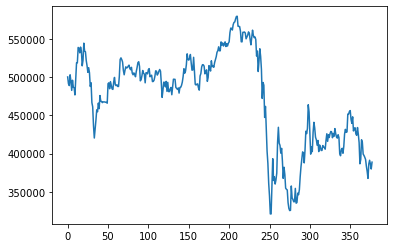

In [34]:
%matplotlib inline
df_account_value.account_value.plot()

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [35]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = BackTestStats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return         -0.154462
Cumulative returns    -0.222502
Annual volatility      0.414766
Sharpe ratio          -0.199458
Calmar ratio          -0.346669
Stability              0.334661
Max drawdown          -0.445562
Omega ratio            0.964303
Sortino ratio         -0.287409
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.873753
Daily value at risk   -0.052584
Alpha                  0.000000
Beta                   1.000000
dtype: float64


<a id='6.2'></a>
## 7.2 BackTestPlot

==============Compare to IHSG===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (367, 8)


Start date,2019-04-02
End date,2020-09-30
Total months,17
,Backtest
Annual return,-14.344%
Cumulative returns,-20.138%
Annual volatility,41.663%
Sharpe ratio,-0.16
Calmar ratio,-0.32
Stability,0.30
Max drawdown,-44.556%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,44.56,2020-02-07,2020-04-07,NaT,NaN
1,22.76,2019-05-03,2019-05-22,2020-01-10,181
2,5.22,2019-04-05,2019-04-15,2019-04-18,10
3,4.54,2019-04-26,2019-04-30,2019-05-03,6
4,1.30,2019-04-23,2019-04-25,2019-04-26,4


Stress Events,mean,min,max
New Normal,-0.03%,-8.61%,11.13%


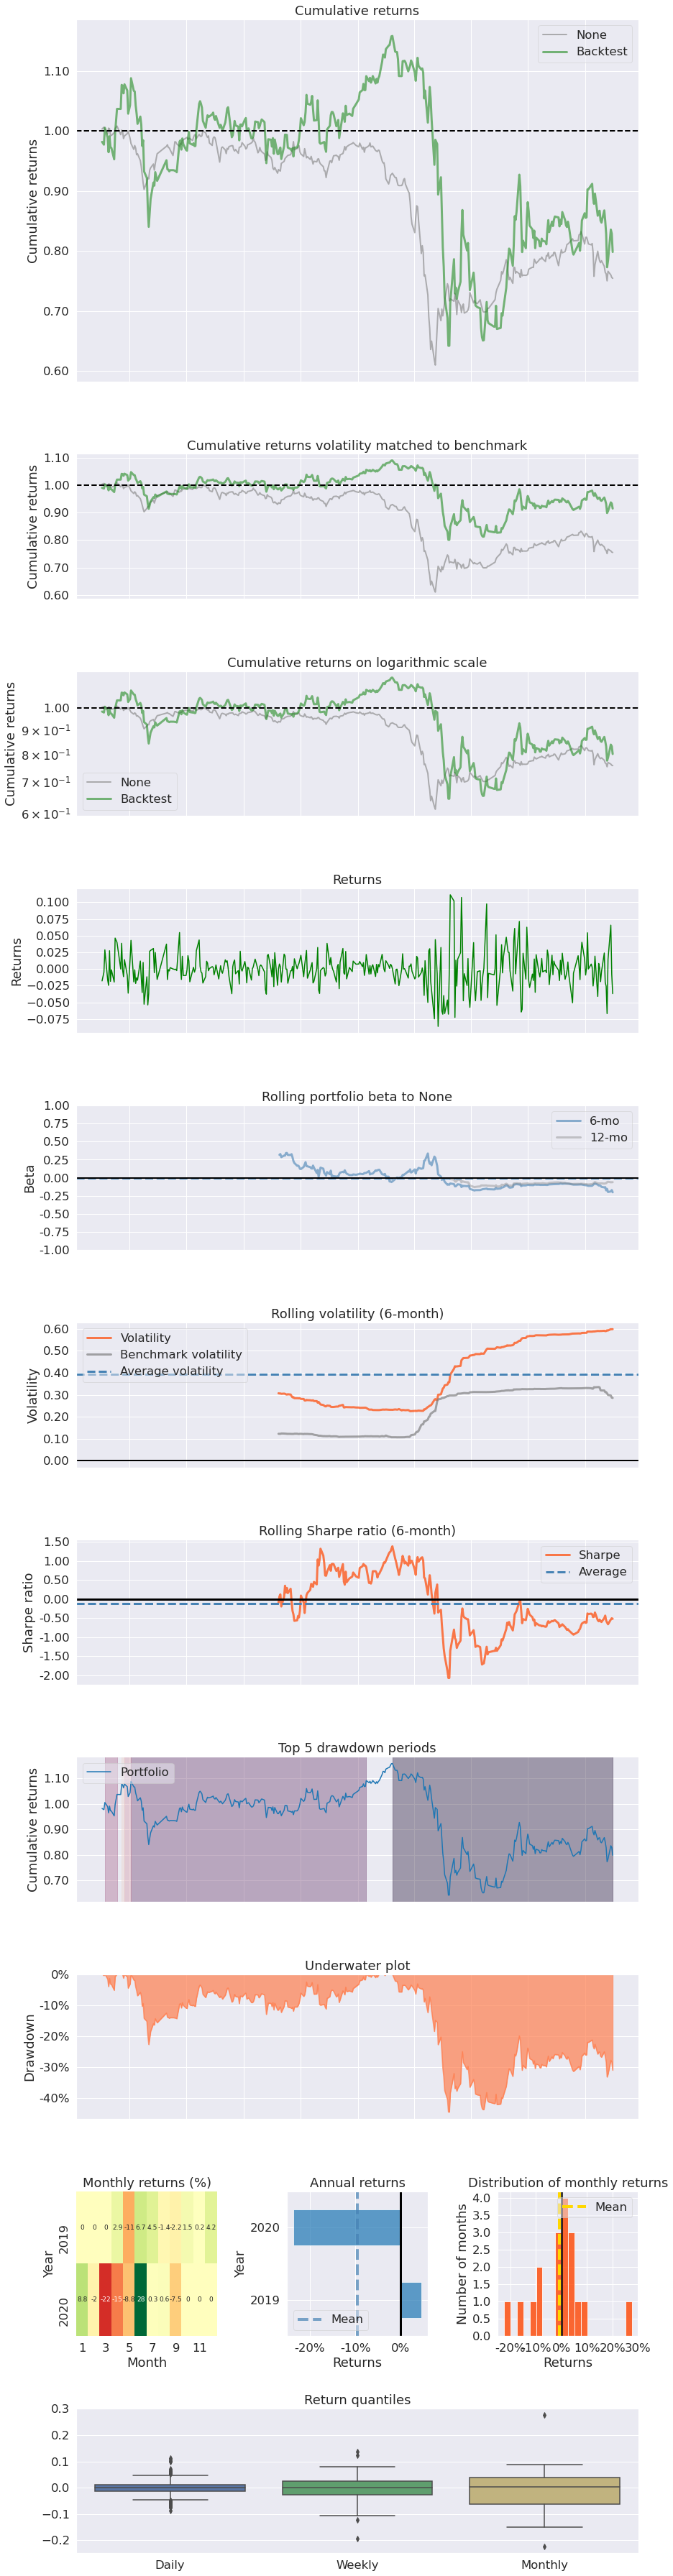

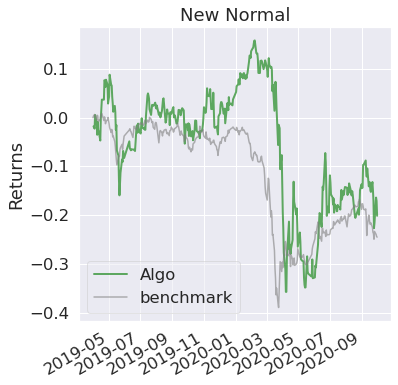

In [43]:
print("==============Compare to IHSG===========")
%matplotlib inline
BackTestPlot(df_account_value, 
             baseline_ticker = '^JKSE', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])

<a id='6.3'></a>
## 7.3 Baseline Stats

In [45]:
print("==============Get Baseline Stats===========")
baseline_perf_stats=BaselineStats('^JKSE',
                                  baseline_start = df_account_value.loc[0,'date'],
                                  baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])
baseline_perf_stats

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (367, 8)
Annual return         -0.175692
Cumulative returns    -0.245261
Annual volatility      0.222469
Sharpe ratio          -0.759802
Calmar ratio          -0.444922
Stability              0.620891
Max drawdown          -0.394883
Omega ratio            0.861198
Sortino ratio         -1.040231
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.892089
Daily value at risk   -0.028699
Alpha                  0.000000
Beta                   1.000000
dtype: float64
